# Building a Trading Robot
## Machine Learning Engineer Nanodegree
**Calvin Ku**
**September 27, 2016**

## Definition
### Project Overview
Problem with trading is that you never know when is the best time to buy or sell a stock, as you never know if the stock price will go up or go down in the future. This simple trading bot is an attempt to solve this problem.

Given the historical data of a stock, our chimp will tell you whether you should buy or sell or hold a particular stock today (in our case, the JPM).
#### Data used in this project
The only data used in this project is the JPM historical data collected from Yahoo Finance. The data ranges from December 30, 1983 to September 27, 2016. We don't use S&P 500 ETF as ETFs are generally arbitrageable which can render the techniques we will use in this project (namely, VPA) useless.


### Problem Statement
This project is about building a trading robot. In this proejct we will call it the Chimp. The Chimp is built to give the common user suggestions on whether to buy or sell or hold a particular stock on a particular trading day. The goal of this project is to build a trading robot that can beat a random monkey bot. Inpired by the famous saying of Princeton University professor Burton Malkiel in 1973 that "A blindfolded monkey throwing darts at a newspaper’s financial pages could select a portfolio that would do just as well as one carefully selected by experts” and the Forbes article [Any Monkey Can Beat the Market](http://www.forbes.com/sites/rickferri/2012/12/20/any-monkey-can-beat-the-market/#da3bf2d6e8b6), instead of competing on a portfolio basis, we set our battlefield on JPM.

We will use JPM as an example in this project but the same method can be applied to any stock. In the end we will evaluate our method by giving the monkey bot (which chooses the three actions equally on a random basis) and our Chimp 1000 dollars and see how they perform from September 26, 2011 to September 27, 2016 on JPM.

### Metrics
In this project we use the cash in hand plus the portfolio value (number of shares in hand times the market price), the total assets as the metric. We also and define the reward function to be the ratio of the difference of the assets divided by the previous assets between the current state and the previous, i.e.:
$$
R(s_i) = \frac{Cash(s_{i + 1}) + PV(s_{i + 1}) - Cash(s_i) - PV(s_i)}{Cash(s_i) + PV(s_i)}
$$

This simple metric is in line with what we want the trading bot to achieve in that our ultimate goal is to make as much profit as possible given what we have put into the market, and it doesn't matter whether it's in cash or in shares.

## Analysis
### Data Exploration
#### First look
Let's first take a glance at some statistics of our data and then see if there's any missing values

In [57]:
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import random
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from copy import copy, deepcopy
from numba import jit

pd.set_option('display.max_columns', 50)

dfSPY = pd.read_csv('allSPY.csv', index_col='Date', parse_dates=True, na_values = ['nan'])
dfJPM = pd.read_csv('JPM.csv', index_col='Date', parse_dates=True, na_values = ['nan'])

# del dfSPY.index.name
del dfJPM.index.name
# display(dfSPY)

start_date = '1983-12-30'
end_date = '2016-09-27'

dates = pd.date_range(start_date, end_date)

dfMain = pd.DataFrame(index=dates)
# dfMain = dfMain.join(dfSPY)
dfMain = dfMain.join(dfJPM)
dfMain.dropna(inplace=True)

print("Start date: {}".format(dfMain.index[0]))
print("End date: {}\n".format(dfMain.index[-1]))

print(dfMain.describe())

Start date: 1983-12-30 00:00:00
End date: 2016-09-27 00:00:00

              Open         High          Low        Close        Volume  \
count  8256.000000  8256.000000  8256.000000  8256.000000  8.256000e+03   
mean     46.472522    47.047441    45.882564    46.475389  1.290023e+07   
std      20.463781    20.687878    20.250667    20.470789  1.835588e+07   
min      10.250010    10.875000     9.624990    10.125000  3.780000e+04   
25%      35.124990    35.527499    34.625010    35.060001  1.882275e+06   
50%      41.000010    41.500000    40.500000    40.965000  7.037000e+06   
75%      52.612501    53.092500    52.000000    52.542501  1.529572e+07   
max     147.000000   149.124985   144.000000   147.000000  2.172942e+08   

         Adj Close  
count  8256.000000  
mean     22.914243  
std      17.191570  
min       1.514014  
25%       5.380651  
50%      23.981890  
75%      33.764691  
max      68.076434  


In [58]:
print("\nInspect missing values:")
display(dfMain.isnull().sum())


Inspect missing values:


Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

Since we won't be using data prior to 1993 for training, we can use SPY (S&P 500 ETF) to get trading days and see if we have any data missing for JPM.

In [61]:
spy_dates = pd.date_range('1993-01-29', end_date)
dfSPY = dfSPY.ix[spy_dates, :]
dfSPY.dropna(inplace=True)
print("Number of trading days: {}".format(len(dfSPY)))
print("Number of days where JPM are traded: {}".format(len(dfMain.ix[dfSPY.index, :])))

Number of trading days: 5960
Number of days where JPM are traded: 5960


It seems to be good. Let's look at the first few lines:

In [3]:
display(dfMain.head())

,Open,High,Low,Close,Volume,Adj Close
1983-12-30,44.000008,44.500006,43.500014,44.000008,211500.0,2.602623
1984-01-03,43.937506,44.249986,43.624979,44.000008,385500.0,2.602623
1984-01-04,44.843758,45.874979,44.249986,45.874979,292500.0,2.713529
1984-01-05,46.812508,47.375008,46.250008,47.375008,344100.0,2.802256
1984-01-06,46.875014,47.375008,46.375021,46.875014,194400.0,2.772681


We can see that we have six columns: Open, High, Low, Close, Volume, Adj Close. The Adj Close is the closing price of that day adjusted for "future" dividends payout and splits. For our usage, we will need to adjust the rest of columns as well.

### Exploratory Visualization
Now let's have a look on the performance of JPM itself:

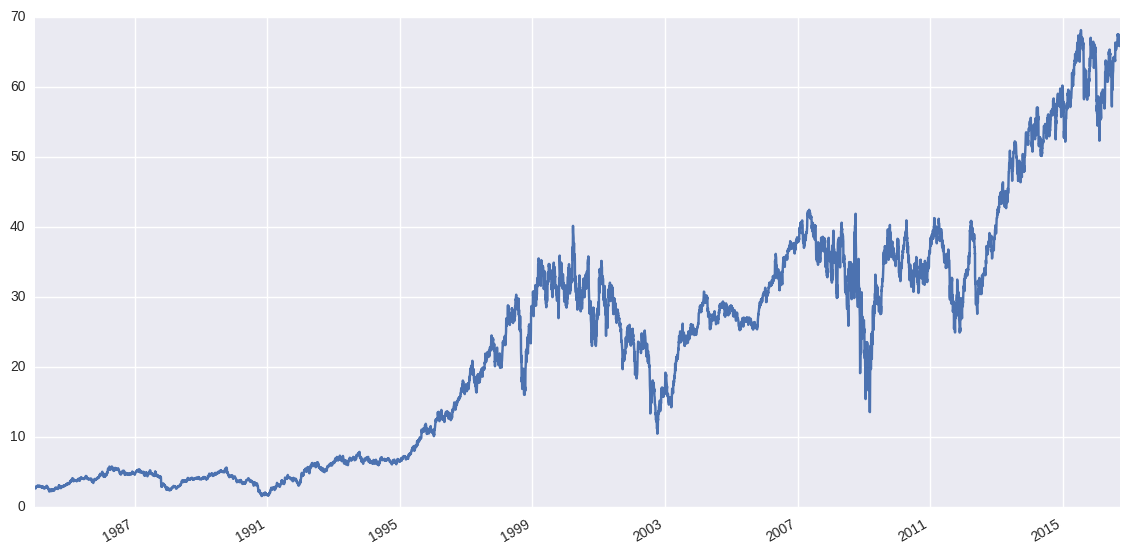

In [4]:
dfMain['Adj Close'].plot(figsize=(14, 7))

Starting from the beginning, the stock price generally has a upward trend, with a bad time from 2001 to 2003 and the crush at the end of 2008.

Now we can take a look at the correlations between the variables:

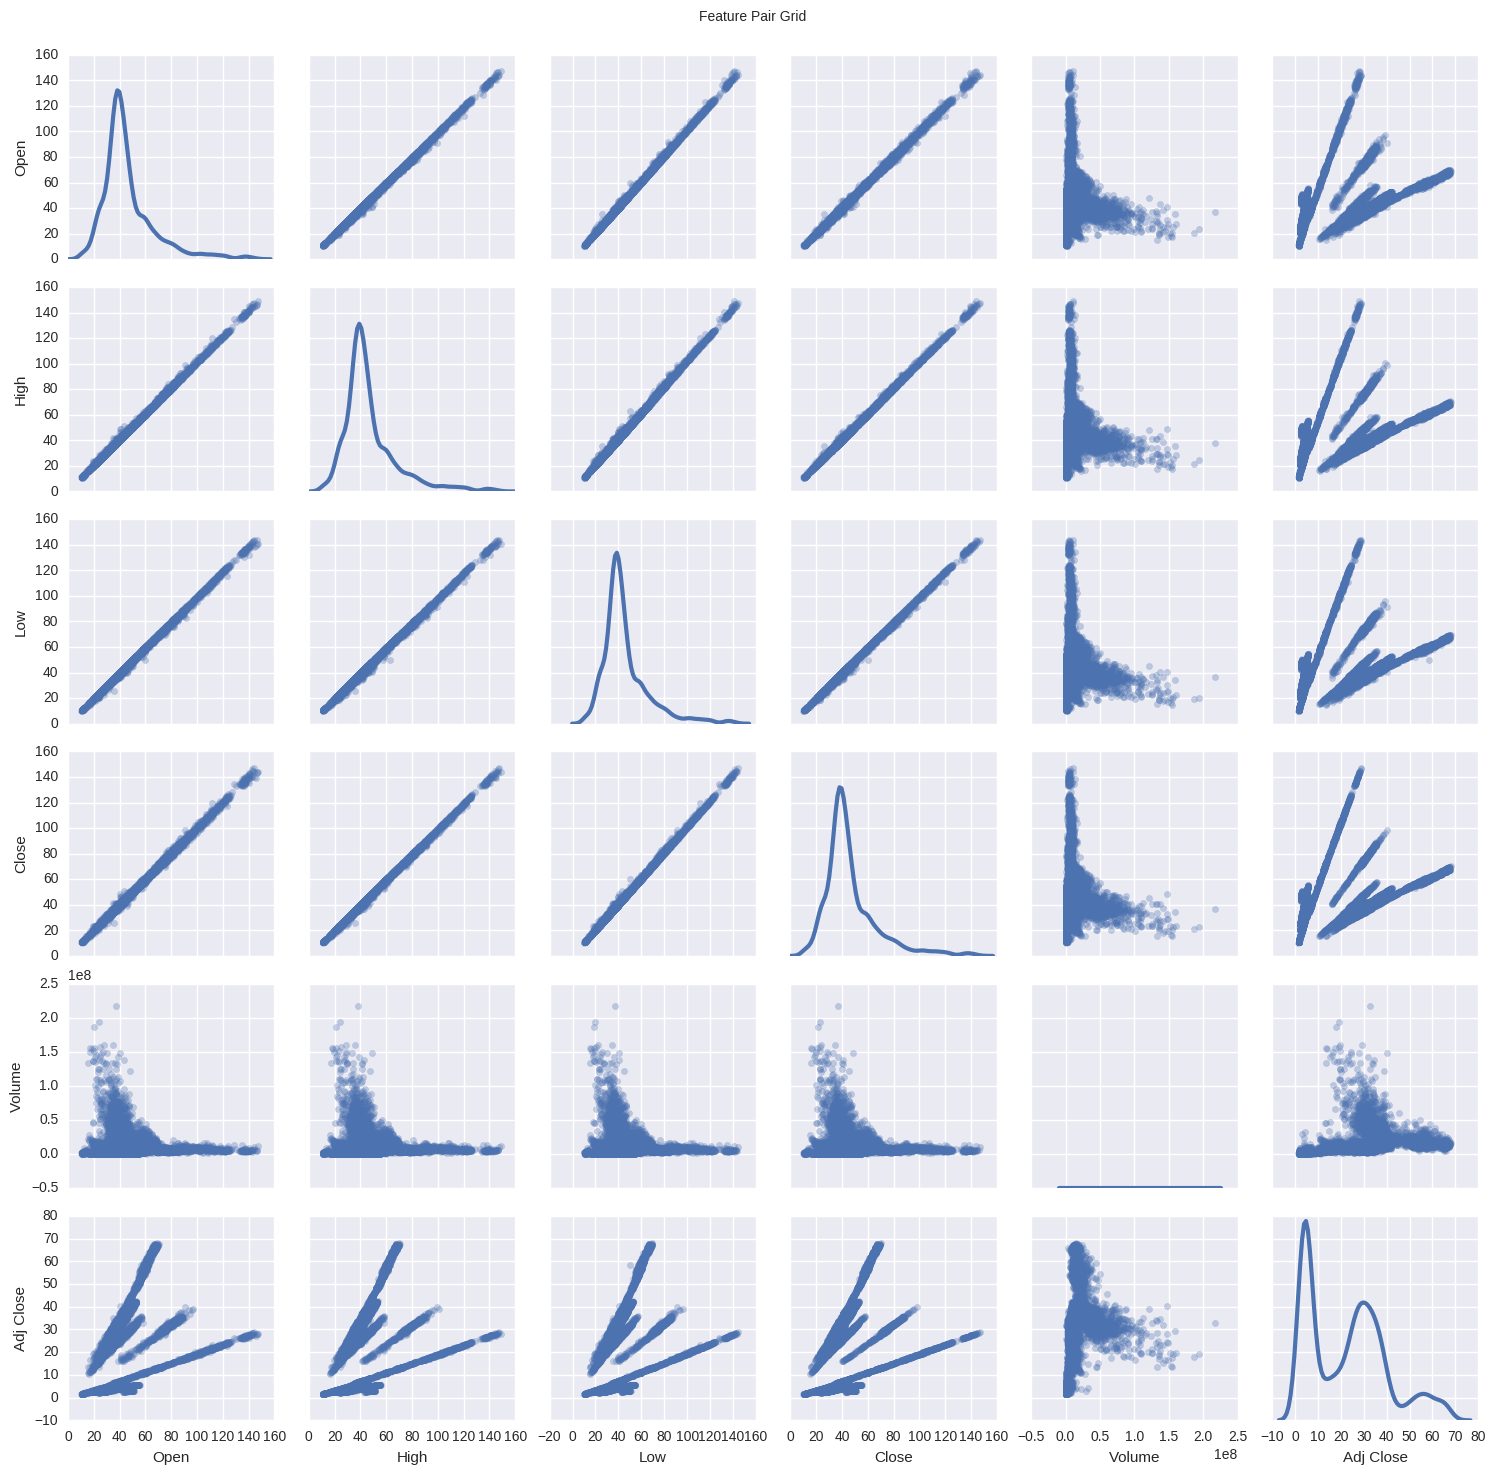

In [5]:
g = sns.PairGrid(dfMain)
g.map_upper(plt.scatter, alpha=0.3)
g.map_lower(plt.scatter, alpha=0.3)
g.map_diag(sns.kdeplot, lw=3, legend=False)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Feature Pair Grid')

We can see it clearly on the `Adj Close` rows and columns there are several lines. This is due to the fact that the `Adj Close` varaible are adjusted for times where there are splits and dividends payout. From here we know we'll need to adjust other variables to match it.

### Algorithms and Techniques
#### Algorithms overview
The trading bot (from now on we refer to it as the *Chimp*, coined with our wishful expectation that she will be smarter than the Monkey Trader) consists of two parts. In the first part we implement Q-learning and run it through the historical data for some number of iterations to construct the Q-table. The Chimp can then go with the optimal policy by following the action of which the state-action pair has the maximum Q value. However, since the state space is vast and the coverage of the Q-table is very small, in the second part we use supervised learning to train on the Q-table and make predictions for the unseen states.

#### Reinfocement learning
##### Q-learning
The core idea of reinforcement learning is simple.
1. The Chimp senses its environment (data of some sort)
2. The Chimp takes an action
3. The Chimp gets a reward for that action she took
4. The Chimp "remembers" the association between the state-action pair and the reward, so next time when she is in the same situation, she'd carry out the action that she thinks best, under the condition that,
5. The Chimp has a really good memory so she doesn't just remember the immediate reward for each state-action pair, she also remembers all the rewards that are prior to and lead to the current state-action pair so that she can maximize the total reward she get

One way to do this is to use a method called **Q-learning**. At the core of Q-learning is the **Bellman equation**.

In each iteration we use the Bellman equation to update the cell of our Q-table:
$$
Q(s, a) \longleftarrow (1 - \alpha) \ Q(s, a) + \alpha \ (R(s) + \gamma  \ max_{a'} Q(s', a'))
$$

where (s, a) is the state-action pair, $\alpha$ the learning rate, $R(s)$ the reward function, and $\gamma$ the discount factor.
And then the Chimp will follow the policy:
$$
\pi(s) = argmax_{a}Q(s, a)
$$

Although we don't have the Q value of any state-action pair to begin with, the reward function contains the "real" information and throughout the iterations that information will slowly propagate to each state-action pair. At some point the Q values will converge to a practical level (hopefully), and we end up with a Q table in psudo-equilibrium.

##### Exploration-exploitation dilemma
However, there's a catch. How does the Chimp know what to do before she has learned anything?

One important concept of reinforcement learning is the **exploration-exploitation dilemma**. Essentially it means when we take an action, we have to choose between whether to explore new possibilities, or just to follow what we've known to be best, to the best of our knowledge. And of course, if we don't know much, then following that limited knowledge of ours wouldn't make much sense. On the other hand, if we've already known pretty much everything, then there's just not much to explore, and wandering around mindlessly wouldn't make sense either.

To implement this concept, we want our Chimp to set out not having a bias (not that she's got much anyways), so we introduce the variable $\epsilon$, which represents the possibility of the Chimp taking random actions. Initially we set $\epsilon = 1$ , and gradually decreases its value as the Chimp getting to know more and more about its environment. As time goes, the Chimp will become wiser and wiser and spends most of her time following what's best for her, and less time on being an explorer.

#### Supervised learning with random forest
For the supervised learning part, we will use the random forest. The random forest doesn't expect linear features or assuming features interacting with each other linearly. It has the advantage of a decision tree which generally can fit into any shape of data, while being ensemble and eliminates the problem of a decision tree being easily overfitting. The random and ensemble nature of the algorithm makes it very unlikely to overfit on the training data. Since we are combining supervised learning with reinforcement learning, the problem gets more complicated and we will have more parameters to tune, and it's good to have an algorithm that kind of works "out of the box" most of the time. On the other hand, random forest handles high dimensionality very well, which makes feature engineering a bit easier where we don't need to worry too much about whether it's the newly engineered features not representative or it's the algorithm not able to handle the enlarged dimensionality. In addition to this, random forest itself is very easy to tune. We can easily grid search through number of choices of features for each splitting and the number of trees. The ensemble nature of the algorithm also makes it scalable when we need to: 1. train on more data, 2. build more trees, 3. take more stocks into account . Overall, random forest generally gives good results and it has been recognized that ensemble algorithms like random forest perform over other traditional algorithms in the Kaggle community over the years and have become quite popular.

##### How it works
The random forest is an ensemble method, which "ensembles" a bunch of decision trees. Each decision tree is generated by creating "nodes" with features in our dataset. 

##### Decision tree
In the training stage, a data point comes down and through the nodes of the decision tree. Each node classifies the data point and sends it to the next node. Say, for example we are classifying people to determine whether their annual income is above or below average, and one feature of our data is gender. And we will probably have values like male/female/other. Now say this data point is a female, then it will get sent down the path accordingly to the next node. The node at the bottom of the decision tree is sometimes referred to as a leaf. Our data point will end up in one of the leaves, and the label of the data point is going to mark that leaf. For example, if our data point is above income average, then we mark that leaf as "above count +1". At the end of the training, all leaves will be marked with labels above or below.

In the predicting stage, we run data down the decision tree and see which leaves they end up with. And then we assign the data the labels of the leaves accordingly.

##### The ensembleness
We now know how each decision tree is constructed and have a forest of decision trees. The last step is to get these decision trees to vote. If 10 trees say this person is above and 5 say below, we predict the person as above. 

##### Randomness of random forest
As said earlier, the decision trees are constructed with the features of our dataset. However, not all of the features are used to construct each decision tree. This is where the random part of the algorithm comes in. Most implementation employs a method called bagging, which generates $m$ sub-datasets from the feature space of the orginal dataset by sampling with replacement, where the size of the sub-datasets is $n'$, relative to the size of the feature space of the original dataset, $n$. The features of each bag are then used to construct a decision tree model.

##### Other parts of random forest
We won't cover everything about the random forest here. However it's worth noting some of the more important specifics of random forest that are not covered here:
* Binning of the continuous variables—which are done slightly differently from implementation to implementation
* Splitting methods—when constructing the decision trees we need to decide which feature to be placed on top of the tree and which to be put at the bottom. 
* Voting methods—we can decide to give each decision tree with the same voting power, or not.
* Modification of the algorithm for regression problems (recursive partitioning)

### Benchmark
We shall set three different benchmarks here. One theoretical, and two practical.

#### Theoretical benchmark
Since our goal is to make as much money as possible. The best role model we can have, would be a *God Chimp*. A God Chimp is a Chimp that can foresee the future, and trades accordingly. In our case, this is not very hard to do. We can instantiate a Chimp object and get her to iterate through the entire dataset, until the whole Q-table converges. And with that Q-table in hand, we can get the psudo-perfect action series, which can make us a good deal of money. We then compute the accuracy of the action series of our *mortal Chimp* for that of the God Chimp. Theoretically speaking, the higher the accuracy, the closer the behavior of the mortal Chimp to the God Chimp, the more money the mortal Chimp would be making.

#### Practical benchmarks
That said, the ups and downs of the stock market are not really uniformly distributed. This means our mortal Chimp could have a very decent accuracy for the God Chimp, but say, screwed up most of the important part. And therefore not really doing that well. Conversely, it may appear that our mortal Chimp is doing really terrible mimicing the God Chimp, but still makes a lot of money. So we will need some practical benchmarks that are more down to earth.

We shall test our Chimp against 100,000 random Monkeys and the Patient Trader we have defined earlier. Since these two naive traders don't get influenced by the media or manipulated by the market makers, they are proven to perform better than the average investor. We are happy as long as our Chimp can perform better than the Monkey, which means our Chimp is at least better than chance (and therefore better than any average person), and also it'd be great if she can beat the PT. However beating the PT in general means beating the market, which isn't something really easy to do. So we wouldn't expect that much here.

## Methodology
### Data Preprocessing
#### Adjust prices

In [6]:
display(dfMain.head())

,Open,High,Low,Close,Volume,Adj Close
1983-12-30,44.000008,44.500006,43.500014,44.000008,211500.0,2.602623
1984-01-03,43.937506,44.249986,43.624979,44.000008,385500.0,2.602623
1984-01-04,44.843758,45.874979,44.249986,45.874979,292500.0,2.713529
1984-01-05,46.812508,47.375008,46.250008,47.375008,344100.0,2.802256
1984-01-06,46.875014,47.375008,46.375021,46.875014,194400.0,2.772681


As said earlier, we need to adjust the prices of Open, High, Low, Close, Volume. This can be done by getting the adjustment fact by dividing Adj Close by Close. We then multiply the prices by this factor, and divide the volume by this factor. 

In [7]:
# Adjust Open, High, Low, Volume
dfMain['Adj Factor'] = dfMain['Adj Close'] / dfMain['Close']

dfMain['Open'] = dfMain['Open'] * dfMain['Adj Factor']
dfMain['High'] = dfMain['High'] * dfMain['Adj Factor']
dfMain['Low'] = dfMain['Low'] * dfMain['Adj Factor']
dfMain['Volume'] = dfMain['Volume'] / dfMain['Adj Factor']

dfMain.drop(['Adj Factor'], axis=1, inplace=True)
display(dfMain.head())
display(dfMain.tail())

,Open,High,Low,Close,Volume,Adj Close
1983-12-30,2.602623,2.632198,2.573048,44.000008,3.575624e+06,2.602623
1984-01-03,2.598926,2.617409,2.580440,44.000008,6.517272e+06,2.602623
1984-01-04,2.652532,2.713529,2.617410,45.874979,4.945011e+06,2.713529
1984-01-05,2.768984,2.802256,2.735712,47.375008,5.817363e+06,2.802256
1984-01-06,2.772681,2.802256,2.743106,46.875014,3.286531e+06,2.772681


,Open,High,Low,Close,Volume,Adj Close
2016-09-21,66.839996,67.129997,66.309998,66.839996,14116800.0,66.839996
2016-09-22,66.989998,67.419998,66.839996,67.389999,12781700.0,67.389999
2016-09-23,67.389999,67.900002,67.180000,67.250000,13967400.0,67.250000
2016-09-26,66.599998,66.800003,65.540001,65.779999,16408100.0,65.779999
2016-09-27,65.410004,66.410004,65.110001,66.360001,13580600.0,66.360001


#### Features engineering using volume price analysis
Volume price analysis has been around for over 100 years, and there are many legendary traders who made themselves famous (and wealthy) using it. In addition to this, the basic principle behind it kind of makes sense on its own, that:
1. Price can only be moved by volume; large spread pushed by large volume and small spread by low volume
2. If it's not the case, then there's an anomaly, and you need to be cautious

But then people, especially practioners, tend to think of it as an art rather than science, in that even though you have some clues what's going on on the market, you still don't know what the best timing is. And it takes practice and practice until you "get it". 

For we data scientists, everything is science, including art. If a human can stare at the candlesticks telling you when to buy or sell, so can a computer. Thus the following features are extracted from the raw dataset:

For volume:
* -1d Volume
* -2d Volume
* -3d Volume
* -4d Volume
* -5d Volume
* 10d Average Volume
* 21d Average Volume
* 63d Average Volume

For price:
* -1d Spread
* -2d Spread
* -3d Spread
* -4d Spread
* -5d Spread
* 10d Spread
* 21d Spread
* 63d Spread

For wick:
* -1d upperwick/lowerwick
* -2d upperwick/lowerwick
* -3d upperwick/lowerwick
* -4d upperwick/lowerwick
* -5d upperwick/lowerwick
* 10d upperwick/lowerwick
* 21d upperwick/lowerwick
* 63d upperwick/lowerwick

where *-nd* represents *n* day in the past.

#### More details on feature engineering
The reason why we choose 5, 10, 21, 63 days is because these are the common time ranges used in technical analysis, where 5 days correspond to one trading week, 10 to two, and 21 days correspond to one trading month, 63 to three. We don't want to explode our feature space so to start with we use the most recent 5-day data with longer term average data.

Spread and wicks are terms to describe the status of the candlestick chart (see below).

![candlestick](files/candlestick.png)

The spread describes the thick body part of the candlestick which shows the difference of the opening price and the closing price. The time frame (in terms of opening/closing) can range from minutes to months depending on what we want to look at (in our case, the time frame is one day). The wicks are the thin lines that extend at the top and the bottom, which describe whether there are stocks traded at prices beyond opening/closing prices during the day (or the specific time frame of interest). As shown in the picture, we can have white or black bodies on the candlestick chart to indicate the direction of the pricing movement, with white meaning $\text{closing price} > \text{opening price}$ and vice versa. On the other hand, a *candle* can have  a upperwick and/or a lowerwick or none at all.

Note that to implement Q-learning we need to make the variables discrete. We use 100 day maximum and 100 day average to divide the above features and get relative levels of those features.

#### Trading price
We set the trading price of each trading day to be the Adjusted Close:
$$
Trade Price = Adj\ Close
$$
This information is not available to the Chimp. The properties of the Chimp get updated with this information when she places an order. The portfolio value also gets updated using this price.

In [8]:
# Price Engineering
# Get opens
period_list = [1, 2, 3, 4, 5, 10, 21, 63, 100]
for x in period_list:
    dfMain['-' + str(x) + 'd_Open'] = dfMain['Open'].shift(x)

# Get adjCloses
period_list = xrange(1, 5 + 1)
for x in period_list:
    dfMain['-' + str(x) + 'd_adjClose'] = dfMain['Adj Close'].shift(x)

# Get highs
period_list1 = xrange(1, 5 + 1)
for x in period_list1:
    dfMain['-' + str(x) + 'd_High'] = dfMain['High'].shift(x)

period_list2 = [10, 21, 63, 100]
for x in period_list2:
    dfMain[str(x) + 'd_High'] = dfMain['High'].shift().rolling(window=x).max()

# Get lows
period_list1 = xrange(1, 5 + 1)
for x in period_list1:
    dfMain['-' + str(x) + 'd_Low'] = dfMain['Low'].shift(x)

period_list2 = [10, 21, 63, 100]
for x in period_list2:
    dfMain[str(x) + 'd_Low'] = dfMain['High'].shift().rolling(window=x).min()

In [9]:
# Get Volume Bases
dfMain['100d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=100).mean() * 1.5
dfMain['100d_Max_Vol'] = dfMain['Volume'].shift().rolling(window=100).max()

# Get Spread Bases
dfMain['Abs_Spread'] = np.abs(dfMain['Adj Close'] - dfMain['Open'])
dfMain['Abs_Spread_Shift1'] = dfMain['Abs_Spread'].shift()
dfMain['100d_Avg_Spread'] = dfMain['Abs_Spread_Shift1'].rolling(window=100).mean() * 1.5
dfMain['100d_Max_Spread'] = dfMain['100d_High'] - dfMain['100d_Low']

dfMain.drop(['Abs_Spread_Shift1', 'Abs_Spread'], axis=1, inplace=True)

display(dfMain.tail())
display(dfMain.ix[datetime(2011, 12, 30)][['Open', 'Adj Close']])

,Open,High,Low,Close,Volume,Adj Close,-1d_Open,-2d_Open,-3d_Open,-4d_Open,-5d_Open,-10d_Open,-21d_Open,-63d_Open,-100d_Open,-1d_adjClose,-2d_adjClose,-3d_adjClose,-4d_adjClose,-5d_adjClose,-1d_High,-2d_High,-3d_High,-4d_High,-5d_High,10d_High,21d_High,63d_High,100d_High,-1d_Low,-2d_Low,-3d_Low,-4d_Low,-5d_Low,10d_Low,21d_Low,63d_Low,100d_Low,100d_Avg_Vol,100d_Max_Vol,100d_Avg_Spread,100d_Max_Spread
2016-09-21,66.839996,67.129997,66.309998,66.839996,14116800.0,66.839996,66.750000,66.150002,66.089996,66.290001,66.269997,67.160004,65.750000,62.463746,62.602664,66.459999,66.190002,65.820000,66.639999,66.400002,66.849998,66.639999,66.260002,66.930000,67.250000,67.680000,67.769997,67.769997,67.769997,66.239998,65.849998,65.440002,66.089996,66.209999,66.260002,65.879997,58.296187,58.296187,2.162303e+07,4.445207e+07,0.555336,9.473810
2016-09-22,66.989998,67.419998,66.839996,67.389999,12781700.0,67.389999,66.839996,66.750000,66.150002,66.089996,66.290001,67.220001,66.070000,63.207953,63.198027,66.839996,66.459999,66.190002,65.820000,66.639999,67.129997,66.849998,66.639999,66.260002,66.930000,67.680000,67.769997,67.769997,67.769997,66.309998,66.239998,65.849998,65.440002,66.089996,66.260002,66.139999,58.296187,58.296187,2.158722e+07,4.445207e+07,0.553699,9.473810
2016-09-23,67.389999,67.900002,67.180000,67.250000,13967400.0,67.250000,66.989998,66.839996,66.750000,66.150002,66.089996,67.029999,65.989998,60.012824,62.414134,67.389999,66.839996,66.459999,66.190002,65.820000,67.419998,67.129997,66.849998,66.639999,66.260002,67.430000,67.769997,67.769997,67.769997,66.839996,66.309998,66.239998,65.849998,65.440002,66.260002,66.139999,58.296187,58.296187,2.162404e+07,4.445207e+07,0.558211,9.473810
2016-09-26,66.599998,66.800003,65.540001,65.779999,16408100.0,65.779999,67.389999,66.989998,66.839996,66.750000,66.150002,66.139999,65.910004,58.256495,61.273014,67.250000,67.389999,66.839996,66.459999,66.190002,67.900002,67.419998,67.129997,66.849998,66.639999,67.900002,67.900002,67.900002,67.900002,67.180000,66.839996,66.309998,66.239998,65.849998,66.260002,66.139999,58.296187,58.296187,2.154451e+07,4.445207e+07,0.555250,9.603815
2016-09-27,65.410004,66.410004,65.110001,66.360001,13580600.0,66.360001,66.599998,67.389999,66.989998,66.839996,66.750000,66.110001,66.330002,58.732788,61.124170,65.779999,67.250000,67.389999,66.839996,66.459999,66.800003,67.900002,67.419998,67.129997,66.849998,67.900002,67.900002,67.900002,67.900002,65.540001,67.180000,66.839996,66.309998,66.239998,66.260002,66.260002,59.090007,58.296187,2.153319e+07,4.445207e+07,0.564871,9.603815


Open         29.013163
Adj Close    29.135839
Name: 2011-12-30 00:00:00, dtype: float64

In [10]:
@jit
def relative_transform(num):
    if 0 <= num < 0.25:
        return 1
    elif 0.25 <= num < 0.5:
        return 2
    elif 0.5 <= num < 0.75:
        return 3
    elif 0.75 <= num < 1:
        return 4
    elif 1 <= num:
        return 5
    elif -0.25 <= num < 0:
        return -1
    elif -0.5 <= num < -0.25:
        return -2
    elif -0.75 <= num < -0.5:
        return -3
    elif -1 <= num < -0.75:
        return -4
    elif num < -1:
        return -5
    else:
        num

# Volume Engineering
# Get volumes
period_list = xrange(1, 5 + 1)
for x in period_list:
    dfMain['-' + str(x) + 'd_Vol'] = dfMain['Volume'].shift(x)

# Get avg. volumes
period_list = [10, 21, 63]
for x in period_list:
    dfMain[str(x) + 'd_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=x).mean()

# Get relative volumes 1
period_list = range(1, 5 + 1)
for x in period_list:
    dfMain['-' + str(x) + 'd_Vol1'] = dfMain['-' + str(x) + 'd_Vol'] / dfMain['100d_Avg_Vol']
    dfMain['-' + str(x) + 'd_Vol1'] = dfMain['-' + str(x) + 'd_Vol1'].apply(relative_transform)

# Get relative avg. volumes 1
period_list = [10, 21, 63]
for x in period_list:
    dfMain[str(x) + 'd_Avg_Vol1'] = dfMain[str(x) + 'd_Avg_Vol'] / dfMain['100d_Avg_Vol']
    dfMain[str(x) + 'd_Avg_Vol1'] = dfMain[str(x) + 'd_Avg_Vol1'].apply(relative_transform)

# Get relative volumes 2
period_list = xrange(1, 5 + 1)
for x in period_list:
    dfMain['-' + str(x) + 'd_Vol2'] = dfMain['-' + str(x) + 'd_Vol'] / dfMain['100d_Max_Vol']
    dfMain['-' + str(x) + 'd_Vol2'] = dfMain['-' + str(x) + 'd_Vol2'].apply(relative_transform)

In [11]:
# Spread Engineering
# Get spread
period_list1 = xrange(1, 5 + 1)
period_list2 = [10, 21, 63]

for x in period_list1:
    dfMain['-' + str(x) + 'd_Spread'] = dfMain['-' + str(x) + 'd_adjClose'] - dfMain['-' + str(x) + 'd_Open']    

for x in period_list2:
    dfMain[str(x) + 'd_Spread'] = dfMain['-1d_adjClose'] - dfMain['-' + str(x) + 'd_Open']

# Get relative spread
period_list1 = xrange(1, 5 + 1)
period_list2 = [10, 21, 63]

for x in period_list1:
    dfMain['-' + str(x) + 'd_Spread'] = dfMain['-' + str(x) + 'd_Spread'] / dfMain['100d_Avg_Spread']
    dfMain['-' + str(x) + 'd_Spread'] = dfMain['-' + str(x) + 'd_Spread'].apply(relative_transform)

for x in period_list2:
    dfMain[str(x) + 'd_Spread'] = dfMain[str(x) + 'd_Spread'] / dfMain['100d_Max_Spread']
    dfMain[str(x) + 'd_Spread'] = dfMain[str(x) + 'd_Spread'].apply(relative_transform)

display(dfMain[['-1d_Spread', '-2d_Spread', '-3d_Spread', '-4d_Spread', '-5d_Spread', '21d_Spread']].tail())

,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,21d_Spread
2016-09-21,-3.0,1.0,-2.0,3.0,1.0,1.0
2016-09-22,1.0,-3.0,1.0,-2.0,3.0,1.0
2016-09-23,3.0,1.0,-3.0,1.0,-2.0,1.0
2016-09-26,-2.0,3.0,1.0,-3.0,1.0,1.0
2016-09-27,-5.0,-1.0,3.0,1.0,-3.0,-1.0


In [12]:
# Get wicks
@jit
def upperwick(open, adj_close, high):
    if high > open and high > adj_close:
        return True
    else:
        return False
def lowerwick(open, adj_close, low):
    if low < open and low < adj_close:
        return True
    else:
        return False

start_time = time.time()
    
period_list1 = xrange(1, 5 + 1)
period_list2 = [10, 21, 63, 100]
for x in period_list1:
    dfMain.ix[:, '-' + str(x) + 'd_upperwick_bool'] = dfMain.apply(lambda row: upperwick(row['-' + str(x) + 'd_Open'], row['-' + str(x) + 'd_adjClose'], row['-' + str(x) + 'd_High']), axis=1)
    dfMain.ix[:, '-' + str(x) + 'd_lowerwick_bool'] = dfMain.apply(lambda row: lowerwick(row['-' + str(x) + 'd_Open'], row['-' + str(x) + 'd_adjClose'], row['-' + str(x) + 'd_Low']), axis=1)
    
for x in period_list2:
    dfMain.ix[:, str(x) + 'd_upperwick_bool'] = dfMain.apply(lambda row: upperwick(row['-' + str(x) + 'd_Open'], row['-1d_adjClose'], row[str(x) + 'd_High']), axis=1)
    dfMain.ix[:, str(x) + 'd_lowerwick_bool'] = dfMain.apply(lambda row: lowerwick(row['-' + str(x) + 'd_Open'], row['-1d_adjClose'], row[str(x) + 'd_Low']), axis=1)

print("Getting wicks took {} seconds.".format(time.time() - start_time))

Getting wicks took 8.72208499908 seconds.


In [13]:
@jit
def get_upperwick_length(open, adj_close, high):
    return high - max(open, adj_close)
@jit
def get_lowerwick_length(open, adj_close, low):
    return min(open, adj_close) - low
    
start_time = time.time()

# Transform upper wicks
period_list1 = xrange(1, 5 + 1)
period_list2 = [10, 21, 63]

for x in period_list1:
    has_upperwicks = dfMain['-' + str(x) + 'd_upperwick_bool']
    has_lowerwicks = dfMain['-' + str(x) + 'd_lowerwick_bool']
    
    dfMain.loc[has_upperwicks, '-' + str(x) + 'd_upperwick'] = dfMain.loc[has_upperwicks, :].apply(lambda row: get_upperwick_length(row['-' + str(x) + 'd_Open'], row['-' + str(x) + 'd_adjClose'], row['-' + str(x) + 'd_High']), axis=1)
    dfMain.loc[has_lowerwicks, '-' + str(x) + 'd_lowerwick'] = dfMain.loc[has_lowerwicks, :].apply(lambda row: get_lowerwick_length(row['-' + str(x) + 'd_Open'], row['-' + str(x) + 'd_adjClose'], row['-' + str(x) + 'd_Low']), axis=1)
    
    # Get relative upperwick length
    dfMain.loc[dfMain['-' + str(x) + 'd_upperwick_bool'], '-' + str(x) + 'd_upperwick'] = dfMain.loc[dfMain['-' + str(x) + 'd_upperwick_bool'], '-' + str(x) + 'd_upperwick'] / dfMain.loc[dfMain['-' + str(x) + 'd_upperwick_bool'], '100d_Avg_Spread']
    # Get relative lowerwick length
    dfMain.loc[dfMain['-' + str(x) + 'd_lowerwick_bool'], '-' + str(x) + 'd_lowerwick'] = dfMain.loc[dfMain['-' + str(x) + 'd_lowerwick_bool'], '-' + str(x) + 'd_lowerwick'] / dfMain.loc[dfMain['-' + str(x) + 'd_lowerwick_bool'], '100d_Avg_Spread']

    # Transform upperwick ratio to int
    dfMain.loc[dfMain['-' + str(x) + 'd_upperwick_bool'], '-' + str(x) + 'd_upperwick'] = dfMain.loc[dfMain['-' + str(x) + 'd_upperwick_bool'], '-' + str(x) + 'd_upperwick'].apply(relative_transform)
    # Transform lowerwick ratio to int
    dfMain.loc[dfMain['-' + str(x) + 'd_lowerwick_bool'], '-' + str(x) + 'd_lowerwick'] = dfMain.loc[dfMain['-' + str(x) + 'd_lowerwick_bool'], '-' + str(x) + 'd_lowerwick'].apply(relative_transform)

    # Assign 0 to no-upperwick days
    dfMain.loc[np.logical_not(dfMain['-' + str(x) + 'd_upperwick_bool']), '-' + str(x) + 'd_upperwick'] = 0
    # Assign 0 to no-lowerwick days
    dfMain.loc[np.logical_not(dfMain['-' + str(x) + 'd_lowerwick_bool']), '-' + str(x) + 'd_lowerwick'] = 0

for x in period_list2:
    has_upperwicks = dfMain[str(x) + 'd_upperwick_bool']
    has_lowerwicks = dfMain[str(x) + 'd_lowerwick_bool']
        
    dfMain.loc[has_upperwicks, str(x) + 'd_upperwick'] = dfMain.loc[has_upperwicks, :].apply(lambda row: get_upperwick_length(row['-' + str(x) + 'd_Open'], row['-1d_adjClose'], row[str(x) + 'd_High']), axis=1)
    dfMain.loc[has_lowerwicks, str(x) + 'd_lowerwick'] = dfMain.loc[has_lowerwicks, :].apply(lambda row: get_lowerwick_length(row['-' + str(x) + 'd_Open'], row['-1d_adjClose'], row[str(x) + 'd_Low']), axis=1)
    
    # Get relative upperwick length
    dfMain.loc[dfMain[str(x) + 'd_upperwick_bool'], str(x) + 'd_upperwick'] = dfMain.loc[dfMain[str(x) + 'd_upperwick_bool'], str(x) + 'd_upperwick'] / dfMain.loc[dfMain[str(x) + 'd_upperwick_bool'], '100d_Avg_Spread']
    # Get relative lowerwick length
    dfMain.loc[dfMain[str(x) + 'd_lowerwick_bool'], str(x) + 'd_lowerwick'] = dfMain.loc[dfMain[str(x) + 'd_lowerwick_bool'], str(x) + 'd_lowerwick'] / dfMain.loc[dfMain[str(x) + 'd_lowerwick_bool'], '100d_Avg_Spread']

    # Transform upperwick ratio to int
    dfMain.loc[dfMain[str(x) + 'd_upperwick_bool'], str(x) + 'd_upperwick'] = dfMain.loc[dfMain[str(x) + 'd_upperwick_bool'], str(x) + 'd_upperwick'].apply(relative_transform)
    # Transform lowerwick ratio to int
    dfMain.loc[dfMain[str(x) + 'd_lowerwick_bool'], str(x) + 'd_lowerwick'] = dfMain.loc[dfMain[str(x) + 'd_lowerwick_bool'], str(x) + 'd_lowerwick'].apply(relative_transform)
    
    # Assign 0 to no-upperwick days
    dfMain.loc[np.logical_not(dfMain[str(x) + 'd_upperwick_bool']), str(x) + 'd_upperwick'] = 0
    # Assign 0 to no-lowerwick days
    dfMain.loc[np.logical_not(dfMain[str(x) + 'd_lowerwick_bool']), str(x) + 'd_lowerwick'] = 0

print("Transforming wicks took {} seconds.".format(time.time() - start_time))

Transforming wicks took 7.03627705574 seconds.


In [14]:
display(dfMain[['-1d_lowerwick', '-2d_lowerwick', '-3d_lowerwick', '-4d_lowerwick', '-5d_lowerwick', '10d_lowerwick', '21d_lowerwick', '63d_lowerwick']].isnull().sum())

-1d_lowerwick    65
-2d_lowerwick    65
-3d_lowerwick    65
-4d_lowerwick    64
-5d_lowerwick    63
10d_lowerwick    30
21d_lowerwick    41
63d_lowerwick    27
dtype: int64

In [15]:
display(dfMain.head())
display(dfMain.tail())

,Open,High,Low,Close,Volume,Adj Close,-1d_Open,-2d_Open,-3d_Open,-4d_Open,-5d_Open,-10d_Open,-21d_Open,-63d_Open,-100d_Open,-1d_adjClose,-2d_adjClose,-3d_adjClose,-4d_adjClose,-5d_adjClose,-1d_High,-2d_High,-3d_High,-4d_High,-5d_High,...,-5d_lowerwick_bool,10d_upperwick_bool,10d_lowerwick_bool,21d_upperwick_bool,21d_lowerwick_bool,63d_upperwick_bool,63d_lowerwick_bool,100d_upperwick_bool,100d_lowerwick_bool,-1d_upperwick,-1d_lowerwick,-2d_upperwick,-2d_lowerwick,-3d_upperwick,-3d_lowerwick,-4d_upperwick,-4d_lowerwick,-5d_upperwick,-5d_lowerwick,10d_upperwick,10d_lowerwick,21d_upperwick,21d_lowerwick,63d_upperwick,63d_lowerwick
1983-12-30,2.602623,2.632198,2.573048,44.000008,3.575624e+06,2.602623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984-01-03,2.598926,2.617409,2.580440,44.000008,6.517272e+06,2.602623,2.602623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.602623,NaN,NaN,NaN,NaN,2.632198,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984-01-04,2.652532,2.713529,2.617410,45.874979,4.945011e+06,2.713529,2.598926,2.602623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.602623,2.602623,NaN,NaN,NaN,2.617409,2.632198,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984-01-05,2.768984,2.802256,2.735712,47.375008,5.817363e+06,2.802256,2.652532,2.598926,2.602623,NaN,NaN,NaN,NaN,NaN,NaN,2.713529,2.602623,2.602623,NaN,NaN,2.713529,2.617409,2.632198,NaN,NaN,...,False,False,False,False,False,False,False,False,False,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984-01-06,2.772681,2.802256,2.743106,46.875014,3.286531e+06,2.772681,2.768984,2.652532,2.598926,2.602623,NaN,NaN,NaN,NaN,NaN,2.802256,2.713529,2.602623,2.602623,NaN,2.802256,2.713529,2.617409,2.632198,NaN,...,False,False,False,False,False,False,False,False,False,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Open,High,Low,Close,Volume,Adj Close,-1d_Open,-2d_Open,-3d_Open,-4d_Open,-5d_Open,-10d_Open,-21d_Open,-63d_Open,-100d_Open,-1d_adjClose,-2d_adjClose,-3d_adjClose,-4d_adjClose,-5d_adjClose,-1d_High,-2d_High,-3d_High,-4d_High,-5d_High,...,-5d_lowerwick_bool,10d_upperwick_bool,10d_lowerwick_bool,21d_upperwick_bool,21d_lowerwick_bool,63d_upperwick_bool,63d_lowerwick_bool,100d_upperwick_bool,100d_lowerwick_bool,-1d_upperwick,-1d_lowerwick,-2d_upperwick,-2d_lowerwick,-3d_upperwick,-3d_lowerwick,-4d_upperwick,-4d_lowerwick,-5d_upperwick,-5d_lowerwick,10d_upperwick,10d_lowerwick,21d_upperwick,21d_lowerwick,63d_upperwick,63d_lowerwick
2016-09-21,66.839996,67.129997,66.309998,66.839996,14116800.0,66.839996,66.750000,66.150002,66.089996,66.290001,66.269997,67.160004,65.750000,62.463746,62.602664,66.459999,66.190002,65.820000,66.639999,66.400002,66.849998,66.639999,66.260002,66.930000,67.250000,...,True,True,True,True,False,True,True,True,True,1.0,2.0,4.0,3.0,2.0,3.0,3.0,2.0,5.0,1.0,4.0,2.0,5.0,0.0,5.0,5.0
2016-09-22,66.989998,67.419998,66.839996,67.389999,12781700.0,67.389999,66.839996,66.750000,66.150002,66.089996,66.290001,67.220001,66.070000,63.207953,63.198027,66.839996,66.459999,66.190002,65.820000,66.639999,67.129997,66.849998,66.639999,66.260002,66.930000,...,True,True,True,True,False,True,True,True,True,3.0,4.0,1.0,2.0,4.0,3.0,2.0,3.0,3.0,2.0,4.0,5.0,5.0,0.0,5.0,5.0
2016-09-23,67.389999,67.900002,67.180000,67.250000,13967400.0,67.250000,66.989998,66.839996,66.750000,66.150002,66.089996,67.029999,65.989998,60.012824,62.414134,67.389999,66.839996,66.459999,66.190002,65.820000,67.419998,67.129997,66.849998,66.639999,66.260002,...,True,True,True,True,False,True,True,True,True,1.0,2.0,3.0,4.0,1.0,2.0,4.0,3.0,2.0,3.0,1.0,5.0,3.0,0.0,3.0,5.0
2016-09-26,66.599998,66.800003,65.540001,65.779999,16408100.0,65.779999,67.389999,66.989998,66.839996,66.750000,66.150002,66.139999,65.910004,58.256495,61.273014,67.250000,67.389999,66.839996,66.459999,66.190002,67.900002,67.419998,67.129997,66.849998,66.639999,...,True,True,False,True,False,True,False,True,True,4.0,1.0,1.0,2.0,3.0,4.0,1.0,2.0,4.0,3.0,5.0,0.0,5.0,0.0,5.0,0.0
2016-09-27,65.410004,66.410004,65.110001,66.360001,13580600.0,66.360001,66.599998,67.389999,66.989998,66.839996,66.750000,66.110001,66.330002,58.732788,61.124170,65.779999,67.250000,67.389999,66.839996,66.459999,66.800003,67.900002,67.419998,67.129997,66.849998,...,True,True,False,True,False,True,False,True,True,2.0,2.0,4.0,1.0,1.0,2.0,3.0,4.0,1.0,2.0,5.0,0.0,5.0,0.0,5.0,0.0


In [16]:
dfMain['Trade Price'] = dfMain['Adj Close']
print(dfMain[['Trade Price', 'Open', 'Adj Close']].head())

            Trade Price      Open  Adj Close
1983-12-30     2.602623  2.602623   2.602623
1984-01-03     2.602623  2.598926   2.602623
1984-01-04     2.713529  2.652532   2.713529
1984-01-05     2.802256  2.768984   2.802256
1984-01-06     2.772681  2.772681   2.772681


In [17]:
display(dfMain.columns)

Index([u'Open', u'High', u'Low', u'Close', u'Volume', u'Adj Close',
       u'-1d_Open', u'-2d_Open', u'-3d_Open', u'-4d_Open',
       ...
       u'-4d_lowerwick', u'-5d_upperwick', u'-5d_lowerwick', u'10d_upperwick',
       u'10d_lowerwick', u'21d_upperwick', u'21d_lowerwick', u'63d_upperwick',
       u'63d_lowerwick', u'Trade Price'],
      dtype='object', length=106)

In [18]:
dfMain.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', \
             '-1d_Vol', '-2d_Vol', '-3d_Vol', '-4d_Vol', '-5d_Vol', '10d_Avg_Vol', '21d_Avg_Vol', '63d_Avg_Vol', \
             '-1d_Open', '-2d_Open', '-3d_Open', '-4d_Open', '-5d_Open', '-10d_Open', '-21d_Open', '-63d_Open', '-100d_Open',  \
             '-1d_adjClose', '-2d_adjClose', '-3d_adjClose', '-4d_adjClose', '-5d_adjClose', \
             '-1d_High', '-2d_High', '-3d_High', '-4d_High', '-5d_High', '10d_High', '21d_High', '63d_High', '100d_High',  \
             '-1d_Low', '-2d_Low', '-3d_Low', '-4d_Low', '-5d_Low', '10d_Low', '21d_Low', '63d_Low', '100d_Low',  \
             '100d_Avg_Vol', '100d_Max_Vol', '100d_Avg_Spread', '100d_Max_Spread', \
             '-1d_upperwick_bool', '-2d_upperwick_bool', '-3d_upperwick_bool', '-4d_upperwick_bool', '-5d_upperwick_bool', '10d_upperwick_bool', '21d_upperwick_bool', '63d_upperwick_bool', '100d_upperwick_bool', \
             '-1d_lowerwick_bool', '-2d_lowerwick_bool', '-3d_lowerwick_bool', '-4d_lowerwick_bool', '-5d_lowerwick_bool', '10d_lowerwick_bool', '21d_lowerwick_bool', '63d_lowerwick_bool', '100d_lowerwick_bool'], \
            axis=1, inplace=True)

In [19]:
display(dfMain.columns)
dfMain.dropna(inplace=True)
len(dfMain.columns)

Index([u'-1d_Vol1', u'-2d_Vol1', u'-3d_Vol1', u'-4d_Vol1', u'-5d_Vol1',
       u'10d_Avg_Vol1', u'21d_Avg_Vol1', u'63d_Avg_Vol1', u'-1d_Vol2',
       u'-2d_Vol2', u'-3d_Vol2', u'-4d_Vol2', u'-5d_Vol2', u'-1d_Spread',
       u'-2d_Spread', u'-3d_Spread', u'-4d_Spread', u'-5d_Spread',
       u'10d_Spread', u'21d_Spread', u'63d_Spread', u'-1d_upperwick',
       u'-1d_lowerwick', u'-2d_upperwick', u'-2d_lowerwick', u'-3d_upperwick',
       u'-3d_lowerwick', u'-4d_upperwick', u'-4d_lowerwick', u'-5d_upperwick',
       u'-5d_lowerwick', u'10d_upperwick', u'10d_lowerwick', u'21d_upperwick',
       u'21d_lowerwick', u'63d_upperwick', u'63d_lowerwick', u'Trade Price'],
      dtype='object')

38

In [22]:
data_full = copy(dfMain)

In [23]:
display(data_full.head())
display(data_full.tail())

,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-1d_lowerwick,-2d_upperwick,-2d_lowerwick,-3d_upperwick,-3d_lowerwick,-4d_upperwick,-4d_lowerwick,-5d_upperwick,-5d_lowerwick,10d_upperwick,10d_lowerwick,21d_upperwick,21d_lowerwick,63d_upperwick,63d_lowerwick,Trade Price
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-5.0,-5.0,4.0,-4.0,-2.0,-4.0,-2.0,-3.0,3.0,5.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,3.0,0.0,0.0,5.0,0.0,5.0,0.0,2.474736
1984-05-24,2.0,1.0,5.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0,-5.0,-5.0,-5.0,4.0,-4.0,-4.0,-3.0,-4.0,4.0,0.0,3.0,5.0,0.0,0.0,2.0,0.0,2.0,2.0,4.0,0.0,5.0,0.0,5.0,0.0,2.497335
1984-05-25,5.0,2.0,1.0,5.0,1.0,5.0,3.0,3.0,5.0,1.0,1.0,1.0,1.0,-3.0,-5.0,-5.0,-5.0,4.0,-3.0,-3.0,-4.0,5.0,2.0,4.0,0.0,3.0,5.0,0.0,0.0,2.0,0.0,4.0,0.0,5.0,0.0,5.0,0.0,2.486037
1984-05-29,2.0,5.0,2.0,1.0,5.0,5.0,3.0,3.0,1.0,5.0,1.0,1.0,1.0,-2.0,-3.0,-5.0,-5.0,-5.0,-2.0,-3.0,-3.0,4.0,4.0,5.0,2.0,4.0,0.0,3.0,5.0,0.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0,2.395634
1984-05-30,2.0,2.0,5.0,2.0,1.0,5.0,3.0,3.0,1.0,1.0,5.0,1.0,1.0,-5.0,-2.0,-3.0,-5.0,-5.0,-2.0,-4.0,-4.0,2.0,5.0,4.0,4.0,5.0,2.0,4.0,0.0,3.0,5.0,5.0,0.0,5.0,0.0,5.0,0.0,2.271333


,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-1d_lowerwick,-2d_upperwick,-2d_lowerwick,-3d_upperwick,-3d_lowerwick,-4d_upperwick,-4d_lowerwick,-5d_upperwick,-5d_lowerwick,10d_upperwick,10d_lowerwick,21d_upperwick,21d_lowerwick,63d_upperwick,63d_lowerwick,Trade Price
2016-09-21,2.0,3.0,5.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,3.0,2.0,2.0,-3.0,1.0,-2.0,3.0,1.0,-1.0,1.0,2.0,1.0,2.0,4.0,3.0,2.0,3.0,3.0,2.0,5.0,1.0,4.0,2.0,5.0,0.0,5.0,5.0,66.839996
2016-09-22,3.0,2.0,3.0,5.0,3.0,3.0,3.0,3.0,2.0,1.0,2.0,3.0,2.0,1.0,-3.0,1.0,-2.0,3.0,-1.0,1.0,2.0,3.0,4.0,1.0,2.0,4.0,3.0,2.0,3.0,3.0,2.0,4.0,5.0,5.0,0.0,5.0,5.0,67.389999
2016-09-23,3.0,3.0,2.0,3.0,5.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,3.0,1.0,-3.0,1.0,-2.0,1.0,1.0,4.0,1.0,2.0,3.0,4.0,1.0,2.0,4.0,3.0,2.0,3.0,1.0,5.0,3.0,0.0,3.0,5.0,67.250000
2016-09-26,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,1.0,2.0,-2.0,3.0,1.0,-3.0,1.0,1.0,1.0,4.0,4.0,1.0,1.0,2.0,3.0,4.0,1.0,2.0,4.0,3.0,5.0,0.0,5.0,0.0,5.0,0.0,65.779999
2016-09-27,4.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,1.0,-5.0,-1.0,3.0,1.0,-3.0,-1.0,-1.0,3.0,2.0,2.0,4.0,1.0,1.0,2.0,3.0,4.0,1.0,2.0,5.0,0.0,5.0,0.0,5.0,0.0,66.360001


## Implementation
The problem with time series data in contrast to cross-sectional ones is that we cannot rely on conventional methods such as cross-validation or the usual 4:3:3 train-cv-test testing framework, as all of these methods are based on the assumption that all our data are drawn from the same population and a careful selection of a sample (samples) with proper modelling can say a lot about the entire population (and of course, about the other carefully drawn samples). However, we are not so lucky when it comes to dealing with time series data, mostly because:

1. Most if not all of the time our model really isn't the underlying model, that is, the data doesn't really come from the model we use. So it works only for really limited range of time and as the time series gets longer the difference between our model on the training set and the underlying model starts to show.

2. Essentially the system we are looking at is a time-dependent one so the underlying model itself most likely changes from time to time (unless we're talking about some grand unified model that can model the whole universe), in which case, assuming one model structure will work on the entire period of data is just wishful thinking.

That said, a lot of time we wish that in the process of our research, we can find some "invariants" (or least psudo-invariants) in our data that doesn't change as time goes. Still, we don't know if they are out there or not.

### Training-testing framework
As said above, we will thus employ a training-testing framework that rolls as time goes. In our case, we keep 35 trading months of data for training (how this is determined will be shown later), and use the model to predict for 7 days, and since we are probably more interested in the performance of the JPM of the recent years we will proceed as following:

1. Use data from September 25, 2006 to September 25, 2011 as our validation dataset, and
2. Use data from September 26, 2011 to September 27, 2016 as our test dataset
3. Use 35 months of data prior to prediction period as our training set.

### Parameters for Q learning
We start off setting our parameters as follows:

* Discount factor: $\gamma = 0.75$
* Learning rate: $\alpha = \frac{1}{t}$, where $t$ is the number of time a state-action pair gets updated
* Eploitation-exploration ratio: $\epsilon = \epsilon - \frac{1}{\text{iter_number}}$
* Number of iteration: `iter_number = 5000`

### Other assumptions

1. **Trading price—**as mentioned earlier, we assume the trading price to be the same as the Adjusted Close.

2. **No transaction cost—**this can simplify the problem so that we can focus on modelling.

3. **Two actions**—we limit ourselves to only two actions, buy and sell. Again since there's no transaction cost, buying when there's no cash is equivalent to hold (and similar for the sell case). By limiting the size of the action space it's easier for our Q value to converge.


### Benchmarks for the two phases
As mentioned above, we will use a roll-forward training framework to build our Chimp. We will first give it a few tries and fine-tune our parameters on the validation dataset. We shall call this the **validation phase**. And then we'll move on the to test on the test dataset, which will be referred to as the **test phase**.

We will set up our two benchmarks for the two phases for comparison. To recap, which include:

1. Performances of the Patient Trader
2. Performances of the Monkey
3. Action series of the God Chimp

In [24]:
validation_start_date = datetime(2006, 9, 25)
validation_end_date = datetime(2011, 9, 27)
test_start_date = datetime(2011, 9, 26)
test_end_date = datetime(2016, 9, 27)

print("Validation phase")
print("{0} Trade Price: {1}".format(validation_start_date, data_full.ix[validation_start_date, 'Trade Price']))
print("{0} Trade Price: {1}".format(validation_end_date, data_full.ix[validation_end_date, 'Trade Price']))
validation_phase_data = data_full.ix[validation_start_date:validation_end_date, :]
print("Number of dates in validation dataset: {}\n".format(len(validation_phase_data)))

print("Test phase")
print("{0} Trade Price: {1}".format(test_start_date, data_full.ix[test_start_date, 'Trade Price']))
print("{0} Trade Price: {1}".format(test_end_date, data_full.ix[test_end_date, 'Trade Price']))
test_phase_data = data_full.ix[test_start_date:test_end_date, :]
print("Number of dates in test dataset: {}".format(len(test_phase_data)))

Validation phase
2006-09-25 00:00:00 Trade Price: 36.610129
2011-09-27 00:00:00 Trade Price: 27.422319
Number of dates in validation dataset: 1262

Test phase
2011-09-26 00:00:00 Trade Price: 27.491809
2016-09-27 00:00:00 Trade Price: 66.360001
Number of dates in test dataset: 1260


#### Performances of the Patient Trader
##### Validation phase (2006-9-25 ~ 2011-9-25)
###### Start
$Cash_{init} = 1000.00$

$Share_{init} = 0$

$PV_{init} = 0$

$Trading \ Price_{init} = 36.61$

----------------

$Share_{start} = floor(\frac{1000.00}{36.61}) = 27$

$PV_{start} = 36.61 \cdot 27 = 988.47$

$Cash_{start} = Cash_{init} - PV_{start} = 1000.00 - 988.47 = 11.53$

$Total \ Assets_{start} = Cash_{start} + PV_{start} = 1000.00$

##### End
$Cash_{end} = 11.53$
$Share_{end} = 27$
$Trading \ Price_{end} = 27.42$

----------------

$PV_{end} = 27.42 \cdot 27 = 740.34$

$Total \ Assets_{end}  = Cash_{end} + PV_{end} = 11.53 + 740.34 = 751.87$

We can calculate the annual ROI by solving the following equation for $r_{val}$:
$$
(1 + r)^{1260/252} = 0.7519
$$

$$
\Longrightarrow \boxed{r_{val} = -0.05543464 \approx -5.54\%}
$$
##### Test phase (2006-9-25 ~ 2011-9-25)
Similarly, we will have
$$
\boxed{r_{test} = 0.1912884 \approx 19.13\%}
$$

#### Performances of the Monkey
We use a `MonkeyBot` class which will place one and only one order randomly everyday. We iterate it through the time frame we choose 100,000 times and we get the following distributions:

In [25]:
import random
import time
from copy import deepcopy

class MonkeyBot(object):
    def __init__(self, dfEnv, cash=1000, share=0, pv=0, now_yes_share=0, random_state=0):
        random.seed(random_state)
        self.cash = cash
        self.share = share
        self.pv = pv
        self.pv_history_list = []
        self.action_list = []
        self.env = deepcopy(dfEnv)

    def buy(self, stock_price):
        num_affordable = int(self.cash // stock_price)
        self.cash = self.cash - stock_price * num_affordable
        self.share = self.share + num_affordable
        self.pv = stock_price * self.share
        self.action_list.append('Buy')

    def sell(self, stock_price):
        self.cash = self.cash + stock_price * self.share
        self.pv = 0
        self.share = 0
        self.action_list.append('Sell')
        

    def hold(self, stock_price):
        self.pv = stock_price * self.share
        self.action_list.append('Hold')

    def reset(self):
        self.cash = 1000
        self.share = 0
        self.pv = 0

    def yes_share(self):
        # Represent chimp asset in state_action
        if self.share > 0:
            return 1
        else:
            return 0

    def make_decision(self, x):
        random_choice = random.choice([1, 2])

        if random_choice == 0:
            self.hold(x)
        elif random_choice == 1:
            self.buy(x)
        else:
            self.sell(x)

        return self.pv # for frame-wise operation

    def simulate(self, iters):
        for i in range(iters):
            self.env['Monkey PV'] = self.env['Trade Price'].apply(self.make_decision)
            self.pv_history_list.append(self.env.ix[-1, 'Monkey PV'] + self.cash)
            self.reset()

In [26]:
monkey_val = MonkeyBot(validation_phase_data, random_state=0)

start_time = time.time()
iters = 100000
monkey_val.simulate(iters)
print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))

100000 iterations took 297.804918051 seconds


(array([  6.34800000e+03,   2.08350000e+04,   2.16270000e+04,
          1.65640000e+04,   1.12580000e+04,   7.61500000e+03,
          5.05600000e+03,   3.36200000e+03,   2.14800000e+03,
          1.47100000e+03,   1.01100000e+03,   7.31000000e+02,
          5.09000000e+02,   3.70000000e+02,   2.75000000e+02,
          1.83000000e+02,   1.52000000e+02,   1.26000000e+02,
          1.00000000e+02,   5.10000000e+01,   5.20000000e+01,
          3.90000000e+01,   2.30000000e+01,   2.40000000e+01,
          1.90000000e+01,   1.10000000e+01,   8.00000000e+00,
          4.00000000e+00,   4.00000000e+00,   4.00000000e+00,
          3.00000000e+00,   2.00000000e+00,   3.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

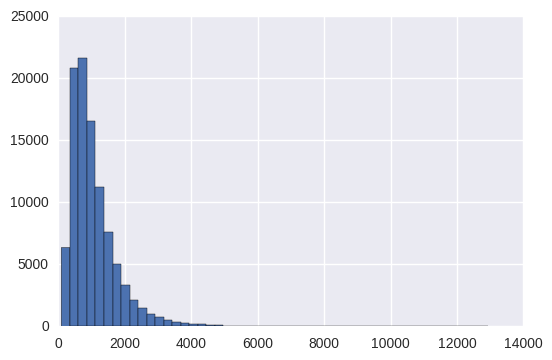

In [27]:
plt.hist(monkey_val.pv_history_list, bins=50)

In [28]:
monkey_val_stats = pd.Series(monkey_val.pv_history_list)
print(monkey_val_stats.describe())

count    100000.000000
mean       1060.238834
std         728.393854
min          85.447874
25%         575.907935
50%         872.079011
75%        1327.014578
max       12935.629597
dtype: float64


In [30]:
monkey_test = MonkeyBot(test_phase_data, random_state=0)

start_time = time.time()
iters = 100000
monkey_test.simulate(iters)
print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))

100000 iterations took 276.959551096 seconds


(array([  4.00000000e+00,   2.10000000e+01,   1.36000000e+02,
          4.72000000e+02,   1.08800000e+03,   2.06900000e+03,
          3.36000000e+03,   4.82700000e+03,   6.27800000e+03,
          7.27500000e+03,   7.81400000e+03,   8.06700000e+03,
          7.98500000e+03,   7.47900000e+03,   7.03600000e+03,
          6.17200000e+03,   5.41600000e+03,   4.60700000e+03,
          4.00500000e+03,   3.22600000e+03,   2.75700000e+03,
          2.14500000e+03,   1.71600000e+03,   1.30400000e+03,
          1.03900000e+03,   8.09000000e+02,   6.83000000e+02,
          5.25000000e+02,   3.81000000e+02,   2.92000000e+02,
          2.53000000e+02,   1.93000000e+02,   1.49000000e+02,
          1.02000000e+02,   7.70000000e+01,   4.60000000e+01,
          4.70000000e+01,   3.40000000e+01,   2.40000000e+01,
          2.50000000e+01,   1.20000000e+01,   1.10000000e+01,
          1.50000000e+01,   7.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   2.00000000e+00,   4.00000000e+00,
        

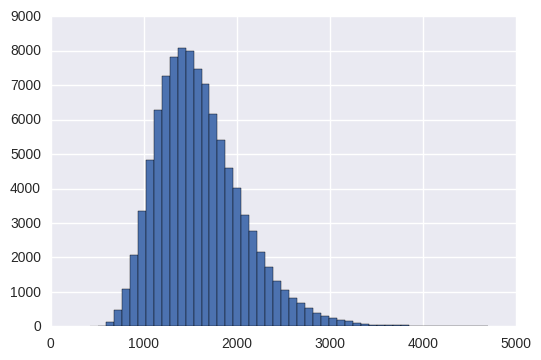

In [31]:
plt.hist(monkey_test.pv_history_list, bins=50)

In [32]:
monkey_test_stats = pd.Series(monkey_test.pv_history_list)
print(monkey_test_stats.describe())

count    100000.000000
mean       1606.960713
std         464.488921
min         422.648034
25%        1272.686842
50%        1542.634717
75%        1869.730139
max        4704.443561
dtype: float64


##### Validation phase (2006-9-25 ~ 2011-9-25)
Using the mean we can calculate $r_{val}$:
$$
(1 + r_{val})^{1260/252} = 0.8721
$$

$$
\Longrightarrow \boxed{r_{val} = -0.02699907 \approx -2.70\%}
$$

##### Test phase (2006-9-25 ~ 2011-9-25)
Similarly,
$$
\Longrightarrow \boxed{r_{test} = 0.09056276 \approx 9.06\%}
$$

#### Action series of the God Chimp

In [33]:
from sklearn.ensemble import RandomForestRegressor

class ChimpBot(MonkeyBot):
    """A trading bot that learns to trade in the stock market."""
    valid_actions = ['Buy', 'Sell']

    epsilon = 1
    gamma = 0.75
    random_reward = [0]

    random_counter = 0
    policy_counter = 0

    track_key1 = {'Sell': 0, 'Buy': 0, 'Hold': 0}
    track_key2 = {'Sell': 0, 'Buy': 0, 'Hold': 0}

    track_random_decision = {'Sell': 0, 'Buy': 0, 'Hold': 0}

    reset_counter = 0

    def __init__(self, dfEnv, iter_random_rounds, test_mode=False, cash=1000, share=0, pv=0, random_state=0):
        super(ChimpBot, self).__init__(dfEnv, iter_random_rounds, cash, share, pv)
        random.seed(random_state)
        np.random.seed(random_state)
        # sets self.cash = 1000
        # sets self.share = 0
        # sets self.pv = 0
        # sets self.pv_history_list = []
        # sets self.env = dfEnv
        # implements buy(self, stock_price)
        # implements sell(self, stock_price)
        # implements hold(self)
        self.test_mode = test_mode
        self.num_features = len(dfEnv.columns) - 1
        self.random_rounds = iter_random_rounds # Number of rounds where the bot chooses to go monkey
        
        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = self.iter_env.next()

        # self.now_yes_share = 0
        self.now_action = ''
        # self.now_q = 0

        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        self.q_df_columns = list(self.env.columns)
        self.q_df_columns.pop()
        self.q_df_columns.extend(['Action', 'Q Value'])
        self.q_df = pd.DataFrame(columns=self.q_df_columns)
        self.q_dict = defaultdict(lambda: (0, 0)) # element of q_dict is (state, act): (q_value, t)
        # self.q_dict_analysis preserves the datetime data and is not used by the ChimpBot
        self.q_dict_analysis = defaultdict(lambda: (0, 0))

        self.negative_reward = 0
        self.n_reward_hisotry = []
        self.net_reward = 0

        self.reset_counter = 0

    def make_q_df(self):
        result_dict = defaultdict(list)

        for index, row in self.q_dict.iteritems():
            for i in range(len(self.q_dict.keys()[0])):
                column_name = 'col' + str(i + 1)
                result_dict[column_name].append(index[i])
            result_dict['Q'].append(self.q_dict[index][0])

        self.q_df = pd.DataFrame(result_dict)
        q_df_column_list = ['col' + str(x) for x in range(1, self.num_features + 1 + 1)]
        q_df_column_list.append('Q')
        self.q_df = self.q_df[q_df_column_list]

        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Wrong action!")

        def str_float_int(x):
            return int(float(x))

        arr_int = np.vectorize(str_float_int)

        self.q_df['col' + str(self.num_features + 1)] = self.q_df['col' + str(self.num_features + 1)].apply(transfer_action)
        self.q_df.ix[:, :-1] = self.q_df.ix[:, :-1].apply(arr_int)

    def split_q_df(self):
        self.q_df_X = self.q_df.ix[:, :-1]
        self.q_df_y = self.q_df.ix[:, -1]

    def train_on_q_df(self):
        reg = RandomForestRegressor(n_estimators=128, max_features='sqrt', n_jobs=-1, random_state=0)
        self.q_reg = reg
        self.q_reg = self.q_reg.fit(self.q_df_X, self.q_df_y)

    def update_q_model(self):
        print("Updating Q model...")
        start_time = time.time()
        self.make_q_df()
        self.split_q_df()
        self.train_on_q_df()

    def from_state_action_predict_q(self, state_action):
        state_action = [state_action]

        pred_q = self.q_reg.predict(state_action)

        return pred_q

    def max_q(self, now_row):
        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Wrong action!")

        def str_float_int(x):
            return int(float(x))

        now_row2 = list(now_row)
        # now_row2.append(self.now_yes_share)
        max_q = ''
        q_compare_dict = {}

        if len(now_row2) > self.num_features:
            raise ValueError("Got ya bastard! @ MaxQ")

        # Populate the q_dict
        for act in set(self.valid_actions):
            now_row2.append(act)
            now_row_key = tuple(now_row2)

            _ = self.q_dict[now_row_key]

            try:
                self.q_reg
            except AttributeError:
                pass
                # print('No q_reg yet...going with default.')
            else:
                if _[1] == 0:

                    single_X = np.array(now_row_key)
                    # print(single_X)
                    arr_int = np.vectorize(str_float_int)
                    single_X[-1] = transfer_action(single_X[-1])
                    single_X = arr_int(single_X)
                    single_X = single_X.reshape(1, -1)
                    pred_q = self.q_reg.predict(single_X)
                    dreamed_q = (1 - (1 / (self.q_dict[now_row_key][1] + 1))) * self.q_dict[now_row_key][0] + (1 / (self.q_dict[now_row_key][1] + 1)) * pred_q[0]
                    self.q_dict[now_row_key] = (dreamed_q, self.q_dict[now_row_key][1] + 1)

            q_compare_dict[now_row_key] = self.q_dict[now_row_key]
            now_row2.pop()

        try:
            max(q_compare_dict.iteritems(), key=lambda x:x[1])
        except ValueError:
            print("Wrong Q Value in Q Compare Dict!")
        else:
            key, qAndT = max(q_compare_dict.iteritems(), key=lambda x:x[1])
            # print("Action: {0}, with Q-value: {1}".format(key[-1], qAndT[0]))
            return key[-1], qAndT[0], qAndT[1]

    def q_update(self):
        # print("Data Index: {}".format(self.now_env_index))
        now_states = list(self.now_row)
        # now_states = list(now_states)
        now_states.pop() # disregard the Trade Price

        prev_states = list(self.prev_states)

        if len(prev_states) > self.num_features:
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the self.prev_states!!!")

        # prev_states.append(self.prev_yes_share)
        prev_states.append(self.prev_action)
        prev_states_key = tuple(prev_states)

        if len(prev_states_key) > self.num_features + 2:
            raise ValueError("Got ya bastard! @ Q_Update")

        q_temp = self.q_dict[prev_states_key]

        q_temp0 = (1 - (1 / (q_temp[1] + 1))) * q_temp[0] + (1 / (q_temp[1] + 1)) * (self.reward + self.gamma * self.max_q(now_states)[1])

        self.q_dict[prev_states_key] = (q_temp0, q_temp[1] + 1)
        # For analysis purpose
        self.q_dict_analysis[prev_states_key] = (q_temp0, self.prev_env_index)
        # print("Now Action: {}".format())
        # print(prev_states_key)
        return (self.q_dict[prev_states_key])

    def policy(self, now_row):
        return self.max_q(now_row)[0]

    def reset(self):
        # Portfolio change over iterations
        self.pv_history_list.append(self.pv + self.cash)

        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = self.iter_env.next()

        self.cash = 1000
        self.share = 0
        self.pv = 0

        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        if self.test_mode is True:
            self.epsilon = 0
        
        else:
            if self.epsilon - 1/self.random_rounds > 1/self.random_rounds: # Epislon threshold: 0.01
                self.random_counter += 1
                self.epsilon = self.epsilon - 1/self.random_rounds
            else:
                self.epsilon = 0.000001 # Epislon threshold: 0.1
                self.policy_counter += 1

        self.net_reward = 0

        self.reset_counter += 1

        if self.reset_counter % self.random_rounds == 0:
            self.update_q_model()

        if self.reset_counter != self.random_rounds:
            self.action_list = []

    def make_decision(self, now_row):
        return self.policy(now_row)

    def update(self):
        # Update state
        now_states = list(self.now_row)

        if len(now_states) > self.num_features + 1:
            print(len(now_states))
            print(self.num_features)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the self.now_row!!!")

        now_states.pop() # disregard the Trade Price

        if len(now_states) > self.num_features:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with now_states after pop!!!")

        # Exploitation-exploration decisioning
        self.decision = np.random.choice(2, p = [self.epsilon, 1 - self.epsilon]) # decide to go random or with the policy
        # self.decision = 0 # Force random mode

        # print("Random decision: {0}, Epislon: {1}".format(self.decision, self.epsilon))
        if self.decision == 0: # if zero, go random
            action = random.choice(self.valid_actions)
        else: # else go with the policy
            action = self.make_decision(now_states)

        if len(now_states) > self.num_features:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with now_states after make_decision!!!")

        # Execute action and get reward
        if action == 'Buy':
            # print(self.now_row)
            self.buy(self.now_row[-1])
        elif action == 'Sell':
            # print(self.now_row)
            self.sell(self.now_row[-1])
        elif action == 'Hold':
            # print(self.now_row)
            self.hold(self.now_row[-1])
        else:
            raise ValueError("Wrong action man!")

        try:
            self.prev_states
        except AttributeError:
            print("Running the first time...no prevs exist.")
        else:
            self.reward = ((self.cash - self.prev_cash) + (self.pv - self.prev_pv)) / (self.prev_cash + self.prev_pv)
            self.q_update()

        self.prev_states = now_states

        if len(now_states) > self.num_features:
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the now_states!!!")

        self.now_action = action
        self.prev_action = action
        # self.prev_yes_share = self.now_yes_share
        self.prev_env_index = deepcopy(self.now_env_index)
        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        try:
            self.now_env_index, self.now_row = self.iter_env.next()
        except StopIteration:
            pass
            # print("End of data.")
        else:
            pass

        try:
            _ = self.reward
        except AttributeError:
            print("No reward yet...0 assigned.")
            self.reward = 0

    def simulate(self):
        start_time = time.time()

        for i in range(self.random_rounds):
            for l in range(len(self.env)):
                self.update()
            self.reset()
        print("{0} rounds of simulation took {1} seconds".format(self.random_rounds, time.time() - start_time))
        return self.pv_history_list

Running the first time...no prevs exist.
No reward yet...0 assigned.
5000 rounds of simulation took 9646.88984394 seconds
2.05413123456e+31


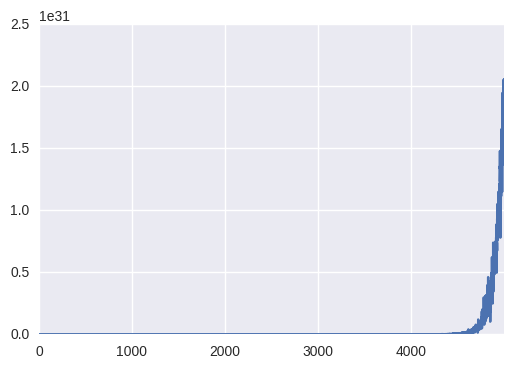

In [1038]:
iter_random_rounds=5000
god_chimp = ChimpBot(dfEnv=data_full, iter_random_rounds=iter_random_rounds, random_state=0)
pv_history_list = god_chimp.simulate()

print(pv_history_list[-1])

pd.Series(pv_history_list).plot()

In [1040]:
print(pd.Series(god_chimp.action_list).describe())

count     8156
unique       2
top        Buy
freq      4123
dtype: object


In [1041]:
# Convert Q-Table to Dataframe from the God Chimp (full dataset)
iter_random_rounds=5000
result_dict = defaultdict(list)
for index, row in god_chimp.q_dict_analysis.iteritems():
    for i in range(len(god_chimp.q_dict_analysis.keys()[0])):
        column_name = 'col' + str(i + 1)
        result_dict[column_name].append(index[i])
    result_dict['Q'].append(god_chimp.q_dict_analysis[index][0])
    result_dict['Date'].append(god_chimp.q_dict_analysis[index][1])

god_chimp_q_df = pd.DataFrame(result_dict)

# Yes share column removed
column_list = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14', 'col15', 'col16', 'col17', 'col18', 'col19', 'col20', 'col21', 'col22', 'col23', 'col24', 'col25', 'col26', 'col27', 'col28', 'col29', 'col30', 'col31', 'col32', 'col33', 'col34', 'col35', 'col36', 'col37', 'col38', 'Date', 'Q']
god_chimp_q_df = god_chimp_q_df[column_list]
god_chimp_q_df.sort_values('Date', inplace=True)
god_chimp_q_df.reset_index(inplace=True)
del god_chimp_q_df['index']

god_chimp_q_df.reset_index(inplace=True)
del god_chimp_q_df['index']

god_chimp_q_df.set_index(god_chimp_q_df['Date'], inplace=True)
del god_chimp_q_df.index.name
del god_chimp_q_df['Date']

print(len(god_chimp_q_df))
display(god_chimp_q_df.head())

16312


,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,Q
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-5.0,-5.0,4.0,-4.0,-2.0,-4.0,-2.0,-3.0,3.0,5.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,3.0,0.0,0.0,5.0,0.0,5.0,0.0,Sell,0.008839
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-5.0,-5.0,4.0,-4.0,-2.0,-4.0,-2.0,-3.0,3.0,5.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,3.0,0.0,0.0,5.0,0.0,5.0,0.0,Buy,0.019101
1984-05-24,2.0,1.0,5.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0,-5.0,-5.0,-5.0,4.0,-4.0,-4.0,-3.0,-4.0,4.0,0.0,3.0,5.0,0.0,0.0,2.0,0.0,2.0,2.0,4.0,0.0,5.0,0.0,5.0,0.0,Sell,0.015100
1984-05-24,2.0,1.0,5.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0,-5.0,-5.0,-5.0,4.0,-4.0,-4.0,-3.0,-4.0,4.0,0.0,3.0,5.0,0.0,0.0,2.0,0.0,2.0,2.0,4.0,0.0,5.0,0.0,5.0,0.0,Buy,0.009537
1984-05-25,5.0,2.0,1.0,5.0,1.0,5.0,3.0,3.0,5.0,1.0,1.0,1.0,1.0,-3.0,-5.0,-5.0,-5.0,4.0,-3.0,-3.0,-4.0,5.0,2.0,4.0,0.0,3.0,5.0,0.0,0.0,2.0,0.0,4.0,0.0,5.0,0.0,5.0,0.0,Buy,-0.015552


In [10]:
def action_to_int(string):
    if string == 'Buy':
        return 1
    elif string == 'Sell':
        return 2
    else:
        return string

god_chimp_q_df.ix[:, -2] = god_chimp_q_df.ix[:, -2].apply(action_to_int)

In [1044]:
god_chimp_q_df.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,Q
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-5.0,-5.0,4.0,-4.0,-2.0,-4.0,-2.0,-3.0,3.0,5.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,3.0,0.0,0.0,5.0,0.0,5.0,0.0,2,0.008839
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-5.0,-5.0,4.0,-4.0,-2.0,-4.0,-2.0,-3.0,3.0,5.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,3.0,0.0,0.0,5.0,0.0,5.0,0.0,1,0.019101
1984-05-24,2.0,1.0,5.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0,-5.0,-5.0,-5.0,4.0,-4.0,-4.0,-3.0,-4.0,4.0,0.0,3.0,5.0,0.0,0.0,2.0,0.0,2.0,2.0,4.0,0.0,5.0,0.0,5.0,0.0,2,0.015100
1984-05-24,2.0,1.0,5.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0,-5.0,-5.0,-5.0,4.0,-4.0,-4.0,-3.0,-4.0,4.0,0.0,3.0,5.0,0.0,0.0,2.0,0.0,2.0,2.0,4.0,0.0,5.0,0.0,5.0,0.0,1,0.009537
1984-05-25,5.0,2.0,1.0,5.0,1.0,5.0,3.0,3.0,5.0,1.0,1.0,1.0,1.0,-3.0,-5.0,-5.0,-5.0,4.0,-3.0,-3.0,-4.0,5.0,2.0,4.0,0.0,3.0,5.0,0.0,0.0,2.0,0.0,4.0,0.0,5.0,0.0,5.0,0.0,1,-0.015552


### Finding the right size for training set 

As said earlier, one problem with time series data is to find the training window size wihtin which the data can be seen as being drawn from the same population as the data we want to predict. Then of course we can generalize what we have learned/modelled from the training to the cross-validation/test dataset.

To do this we can make use of the God Chimp’s Q-table we just got and get:

In [76]:
from sklearn.metrics import accuracy_score

def find_best_training_size(data_full, full_q_df, training_sizes, testing_size, target_data, random_state=0):
    start_time = time.time()
    accs = []
    d_counter = 0

    # Loop through all batches in validation dataset
    (u, ) = data_full.index.get_indexer_for([target_data.index[0]])
    for d in range(u, u + testing_size * (len(target_data) // testing_size), testing_size):
        acc_num_train_months = []
        d_counter += 1

        # Dates in the batch
        date_range = data_full.iloc[d:d + testing_size].index
        
        # Loop through all sizes of training sets
        for num_train_month in range(1, training_sizes + 1):  
            # Prepare Training/Testing Datasets
            X_train = full_q_df.iloc[d - (int(21 * num_train_month)):d, :-1]
            y_train = full_q_df.iloc[d - (int(21 * num_train_month)):d, -1]
            X_test = full_q_df.ix[date_range, :-1]
            y_test = full_q_df.ix[date_range, -1]

            # Fit data and make predictions
            reg = RandomForestRegressor(n_estimators=128, max_features='sqrt', oob_score=True, n_jobs=-1, random_state=random_state)
            reg.fit(X_train, y_train)

            y_pred = reg.predict(X_test)
            y_fit = reg.predict(X_train)

            pred_q = y_pred
            actions = X_test.ix[:, -1]
            data = {'Action': actions, 'Q': pred_q}
            df_pred = pd.DataFrame(data=data, index=y_test.index)

            pred_actions = []

            for date in date_range:  
                max_q = [0, -1]
                for i, r in df_pred.ix[date].iterrows():
                    if r['Q'] > max_q[1]:
                        max_q = [r['Action'], r['Q']]
                pred_actions.append(max_q[0])

            best_actions = []

            for date in date_range:
                max_q = [0, -1]
                for i, r in full_q_df.ix[date].iterrows():
                    if r['Q'] > max_q[1]:
                        max_q = [r[-2], r['Q']]
                best_actions.append(max_q[0])

            acc_num_train_months.append(accuracy_score(best_actions, pred_actions))
        accs.append(np.array(acc_num_train_months))
        print("Batch {0} completed....{1:.2f}%".format(d_counter, d_counter / len(range(u, u + testing_size * (len(target_data) // testing_size), testing_size))))
        geo_means = np.power(reduce(lambda x,y: x*y, accs), (1/len(accs)))
        arithmetic_means = reduce(lambda x,y: x+y, accs) / len(accs)
        print("Geometric Means Max: {}".format((np.argmax(geo_means) + 1, np.max(geo_means))))
        print("Arithemtic Means Max: {}".format((np.argmax(arithmetic_means) + 1, np.max(arithmetic_means))))
    
    print("Grid search best num_train_year took {} seconds:".format(time.time() - start_time))
    
    return (geo_means, arithmetic_means)

In [1046]:
means = find_best_training_size(data_full=data_full, full_q_df=god_chimp_q_df, training_sizes=120, testing_size=7, target_data=validation_phase_data, random_state=0)
geo_means = means[0]
arithmetic_means = means[1]

Batch 1 completed....0.01%
Geometric Means Max: (64, 0.7142857142857143)
Arithemtic Means Max: (64, 0.7142857142857143)
Batch 2 completed....0.01%
Geometric Means Max: (3, 0.5714285714285714)
Arithemtic Means Max: (2, 0.5714285714285714)
Batch 3 completed....0.02%
Geometric Means Max: (96, 0.6256455914125556)
Arithemtic Means Max: (96, 0.66666666666666663)
Batch 4 completed....0.02%
Geometric Means Max: (64, 0.62865124056670951)
Arithemtic Means Max: (26, 0.6428571428571429)
Batch 5 completed....0.03%
Geometric Means Max: (64, 0.61676569768093636)
Arithemtic Means Max: (26, 0.62857142857142867)
Batch 6 completed....0.03%
Geometric Means Max: (99, 0.62103954569315234)
Arithemtic Means Max: (86, 0.6428571428571429)
Batch 7 completed....0.04%
Geometric Means Max: (75, 0.59791895257491678)
Arithemtic Means Max: (75, 0.61224489795918369)
Batch 8 completed....0.04%
Geometric Means Max: (86, 0.58377634280084301)
Arithemtic Means Max: (86, 0.6071428571428571)
Batch 9 completed....0.05%
Geometr

[ 0.46941488  0.          0.46812252  0.          0.          0.          0.
  0.          0.46291511  0.47041653  0.46304303  0.          0.45957992
  0.          0.4666322   0.47626914  0.          0.48214285  0.          0.
  0.          0.48211332  0.          0.          0.48167617  0.          0.
  0.          0.          0.47306257  0.4742388   0.          0.46818833
  0.          0.48574901  0.47116956  0.48761289  0.          0.45552042
  0.47488147  0.          0.          0.          0.47865849  0.46048357
  0.          0.46888289  0.          0.          0.45852544  0.
  0.45188303  0.45495606  0.45458731  0.          0.          0.45398097
  0.          0.          0.          0.47279696  0.44708424  0.47766806
  0.          0.45651616  0.          0.47028094  0.          0.          0.
  0.44763883  0.          0.47323469  0.          0.          0.45097461
  0.46573407  0.44087702  0.46764007  0.4366769   0.          0.          0.
  0.          0.          0.46308693  0

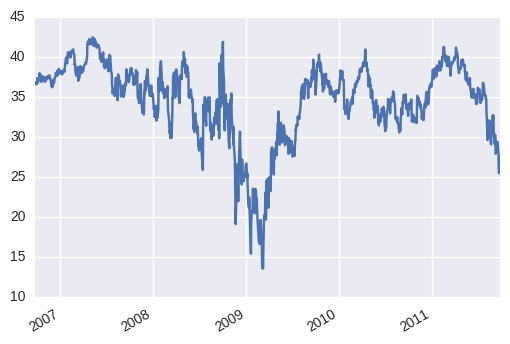

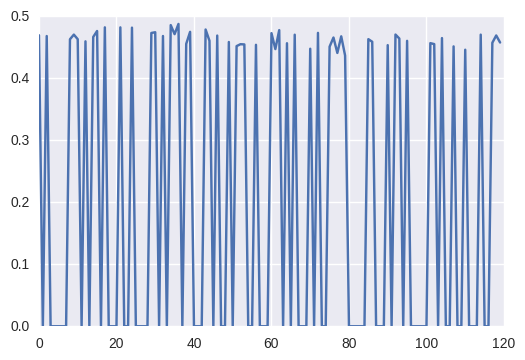

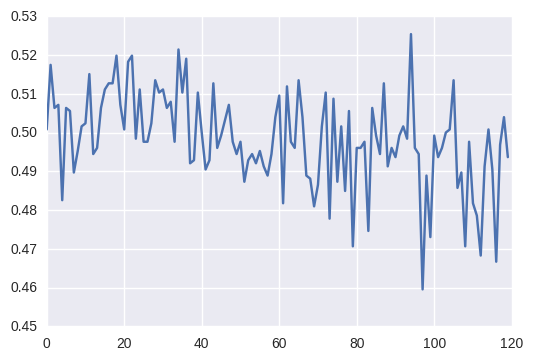

In [1048]:
print(geo_means)
print(sorted(range(len(geo_means)), key=lambda k: geo_means[k], reverse=True))

print(arithmetic_means)
print(sorted(range(len(arithmetic_means)), key=lambda k: arithmetic_means[k], reverse=True))

validation_phase_data['Trade Price'].plot()
plt.figure()
plt.plot(geo_means)
plt.figure()
plt.plot(arithmetic_means)

We can see a trend of accuracies going up and then down again. Here we choose 35 months of data to build our model.

In [142]:
import sys

def chimp_simulate(data_full, target_data, num_iter, train_size, batch_size, random_state=0):
    pv_history_list = []
    action_lists = []
    # Initiating data and the chimp
    start_date = target_data.index[0]
    end_date = target_data.index[-1]
    
    dfFull = data_full
    date_range = target_data.index[:] # Using 7 months of data to predict one month
    print(date_range)
    
    batch_count = 0
        
    cash = 1000
    share = 0
    pv = 0
    now_yes_share = 0

    for batch in range(len(target_data) // batch_size + 1):
        
#     for date in date_range:
        batch_count += 1
        print("Batch {}".format(batch_count))

        try:
            dfTest = dfFull.ix[target_data.index[batch * batch_size]:target_data.index[batch * batch_size + batch_size - 1]]
        except IndexError:
            print("Last batch size unmatched...but may be fine!")
            try: 
                dfTest = dfFull.ix[target_data.index[batch * batch_size]:target_data.index[-1]]
            except IndexError:
                print("End of data")
                return (pv_history_list, action_lists)
        
        (u,) = dfFull.index.get_indexer_for([target_data.index[batch * batch_size]])

        dfTrain = dfFull.iloc[u - (train_size):u]

        chimp_train = ChimpBot(dfTrain, iter_random_rounds=num_iter, random_state=0)

        for i in range(num_iter):
            for l in range(len(chimp_train.env)):
                # print("Train Round {0}-{1}".format(i + 1, l + 1))
                chimp_train.update()
            chimp_train.reset()

        # Test the Chimp!
#         q_df = deepcopy(chimp_train.q_df)
#         q_dict = deepcopy(chimp_train.q_dict)
#         q_reg = deepcopy(chimp_train.q_reg)

        try:
            _ = chimp_test
        except NameError:
            print("First time running...")
                    
#             now_yes_share = chimp_test.now_yes_share

        chimp_test = ChimpBot(dfTest, iter_random_rounds=num_iter, random_state=0)
        
        chimp_test.q_df = deepcopy(chimp_train.q_df)
        chimp_test.q_dict = deepcopy(chimp_train.q_dict)
        chimp_test.q_reg = deepcopy(chimp_train.q_reg)
        chimp_test.epsilon = 0

        # Pass the cheatsheet to the next chimp
        try:
            chimp_test.cash = cash
            chimp_test.share = share
            chimp_test.pv = pv
            
            chimp_test.prev_states = prev_states
            chimp_test.now_action = now_action
            chimp_test.prev_action = prev_action
#             chimp_test.prev_yes_share = prev_yes_share
            chimp_test.reward = reward
            chimp_test.prev_cash = prev_cash
            chimp_test.prev_share = prev_share
            chimp_test.prev_pv = prev_pv
            chimp_test.prev_env_index = prev_env_index

        except UnboundLocalError:
            print("No cheatsheet to pass over yet...no worries!")

        for l in range(len(chimp_test.env)):
            # print("Train Round {0}-{1}".format(i + 1, l + 1))
            chimp_test.update()
            action_lists.append(chimp_test.action_list)
            pv_history_list.append(chimp_test.cash + chimp_test.pv)

                
        # Create cheatsheet for the next chimp
        cash = chimp_test.cash
        share = chimp_test.share
        pv = chimp_test.pv
            
        prev_states = chimp_test.prev_states
        now_action = chimp_test.now_action
        prev_action = chimp_test.prev_action
#         prev_yes_share = chimp_test.prev_yes_share
        prev_env_index = chimp_test.prev_env_index
        reward = chimp_test.reward
        prev_cash = chimp_test.prev_cash
        prev_share = chimp_test.prev_share
        prev_pv = chimp_test.prev_pv
        
        if (batch + 1) % 3 == 0:
            print(pv_history_list)
        
    print(pv_history_list)
    
    return (pv_history_list, action_lists)

In [143]:
validation_phase_data.head()

,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-1d_lowerwick,-2d_upperwick,-2d_lowerwick,-3d_upperwick,-3d_lowerwick,-4d_upperwick,-4d_lowerwick,-5d_upperwick,-5d_lowerwick,10d_upperwick,10d_lowerwick,21d_upperwick,21d_lowerwick,63d_upperwick,63d_lowerwick,Trade Price
2006-09-25,2.0,2.0,3.0,2.0,3.0,3.0,3.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,-3.0,3.0,1.0,-1.0,1.0,1.0,4.0,1.0,2.0,3.0,2.0,3.0,0.0,1.0,4.0,2.0,1.0,5.0,0.0,5.0,2.0,5.0,0.0,36.610129
2006-09-26,4.0,2.0,2.0,3.0,2.0,3.0,3.0,3.0,3.0,1.0,2.0,2.0,2.0,-2.0,1.0,-3.0,3.0,1.0,1.0,1.0,4.0,2.0,2.0,1.0,2.0,3.0,2.0,3.0,0.0,1.0,4.0,5.0,0.0,5.0,2.0,5.0,0.0,36.602326
2006-09-27,4.0,4.0,2.0,2.0,3.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,2.0,-1.0,-2.0,1.0,-3.0,3.0,1.0,1.0,4.0,1.0,4.0,2.0,2.0,1.0,2.0,3.0,2.0,3.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0,36.555499
2006-09-28,3.0,4.0,4.0,2.0,2.0,3.0,3.0,3.0,2.0,2.0,3.0,1.0,2.0,1.0,-1.0,-2.0,1.0,-3.0,1.0,1.0,3.0,3.0,2.0,1.0,4.0,2.0,2.0,1.0,2.0,3.0,2.0,5.0,0.0,5.0,4.0,5.0,4.0,36.797434
2006-09-29,2.0,3.0,4.0,4.0,2.0,3.0,3.0,3.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,-1.0,-2.0,1.0,1.0,1.0,3.0,2.0,1.0,3.0,2.0,1.0,4.0,2.0,2.0,1.0,2.0,3.0,1.0,3.0,4.0,3.0,5.0,36.649150


In [1051]:
start_time = time.time()

result_list = chimp_simulate(data_full=data_full, target_data=validation_phase_data, num_iter=5000, train_size=21*35, batch_size=7, random_state=0)

print("\nSimulation for Validation set took {} seconds.".format(time.time() - start_time))

DatetimeIndex(['2006-09-25', '2006-09-26', '2006-09-27', '2006-09-28',
               '2006-09-29', '2006-10-02', '2006-10-03', '2006-10-04',
               '2006-10-05', '2006-10-06',
               ...
               '2011-09-14', '2011-09-15', '2011-09-16', '2011-09-19',
               '2011-09-20', '2011-09-21', '2011-09-22', '2011-09-23',
               '2011-09-26', '2011-09-27'],
              dtype='datetime64[ns]', length=1262, freq=None)
Batch 1
Running the first time...no prevs exist.
No reward yet...0 assigned.
First time running...
No cheatsheet to pass over yet...no worries!
Running the first time...no prevs exist.
No reward yet...0 assigned.
Batch 2
Running the first time...no prevs exist.
No reward yet...0 assigned.
Batch 3
Running the first time...no prevs exist.
No reward yet...0 assigned.
[1000.0, 1000.0, 998.73567099999991, 1005.2679160000001, 1001.264248, 1001.264248, 1001.264248, 1002.8991539999998, 1002.8991539999998, 991.65893799999992, 991.65893799999992, 1000.

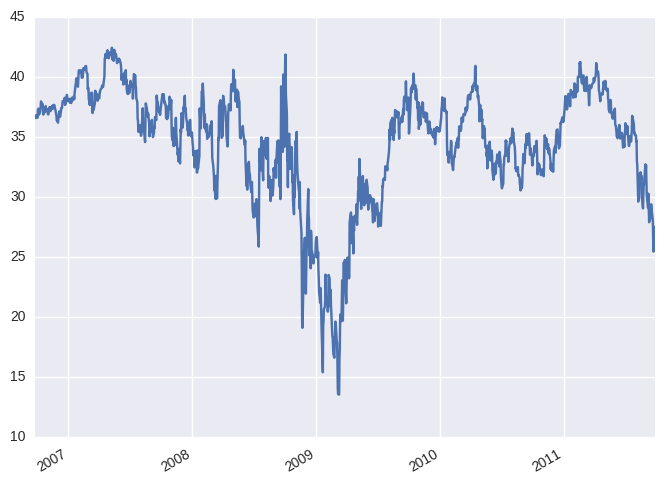

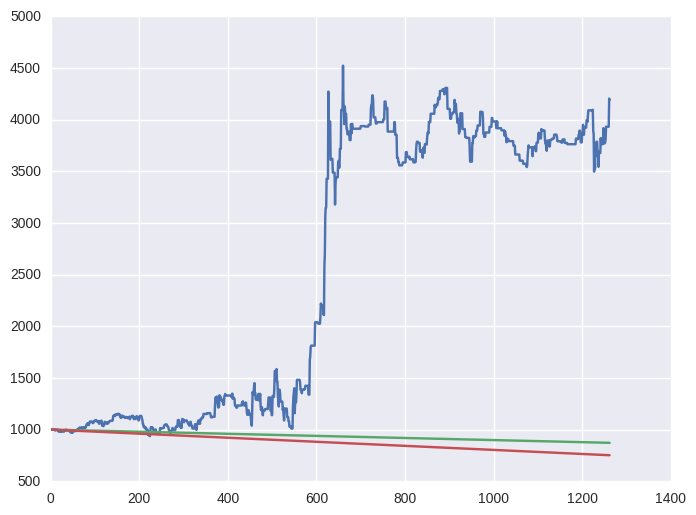

In [1053]:
pv_history_list = result_list[0]
temp_pv_list = [1000]
temp_pv_list.extend(pv_history_list)
pv_history_list = temp_pv_list

plt.figure(figsize=(8,6))
validation_phase_data['Trade Price'].plot()

plt.figure(figsize=(8,6))
plt.plot(pv_history_list)

monkey_x = np.arange(len(pv_history_list))
monkey_y = ((872.08 - 1000)/ len(pv_history_list)) * monkey_x + 1000

plt.plot(monkey_x, monkey_y)
pt_x = np.arange(len(pv_history_list))
pt_y = ((751.87 - 1000)/ len(pv_history_list)) * pt_x + 1000
plt.plot(pt_x, pt_y)

The result turns out to be really good!

And if we look at the equivalent annual ROI:

$$
ROI = (1 + r)^{1262/252} = 4.1928
$$

$$
\Longrightarrow r = 0.3313846 \approx 33.14\%
$$

The result is quite impressive compare to the Patient Trader (-5.54%) and the Monkey (-2.70%). Let's give the test set a shot!

In [144]:
test_phase_data.head()

,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-1d_lowerwick,-2d_upperwick,-2d_lowerwick,-3d_upperwick,-3d_lowerwick,-4d_upperwick,-4d_lowerwick,-5d_upperwick,-5d_lowerwick,10d_upperwick,10d_lowerwick,21d_upperwick,21d_lowerwick,63d_upperwick,63d_lowerwick,Trade Price
2011-09-26,4.0,5.0,4.0,3.0,3.0,4.0,4.0,3.0,2.0,4.0,3.0,2.0,2.0,4.0,-1.0,-5.0,-3.0,-2.0,-1.0,-3.0,-3.0,2.0,1.0,2.0,4.0,2.0,1.0,1.0,1.0,2.0,2.0,5.0,0.0,4.0,0.0,5.0,0.0,27.491809
2011-09-27,4.0,4.0,5.0,4.0,3.0,4.0,4.0,3.0,3.0,2.0,4.0,3.0,2.0,5.0,4.0,-1.0,-5.0,-3.0,-1.0,-1.0,-3.0,1.0,1.0,2.0,1.0,2.0,4.0,2.0,1.0,1.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,27.422319
2011-09-28,4.0,4.0,4.0,5.0,4.0,4.0,4.0,3.0,3.0,3.0,2.0,4.0,3.0,-5.0,5.0,4.0,-1.0,-5.0,-1.0,-2.0,-3.0,3.0,2.0,1.0,1.0,2.0,1.0,2.0,4.0,2.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,26.466837
2011-09-29,3.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0,2.0,3.0,3.0,2.0,4.0,-5.0,-5.0,5.0,4.0,-1.0,-1.0,-2.0,-3.0,2.0,1.0,3.0,2.0,1.0,1.0,2.0,1.0,2.0,4.0,5.0,5.0,4.0,5.0,5.0,5.0,27.265967
2011-09-30,4.0,3.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,2.0,3.0,3.0,2.0,-1.0,-5.0,-5.0,5.0,4.0,-1.0,-2.0,-3.0,3.0,5.0,2.0,1.0,3.0,2.0,1.0,1.0,2.0,1.0,2.0,5.0,3.0,5.0,5.0,5.0,26.162822


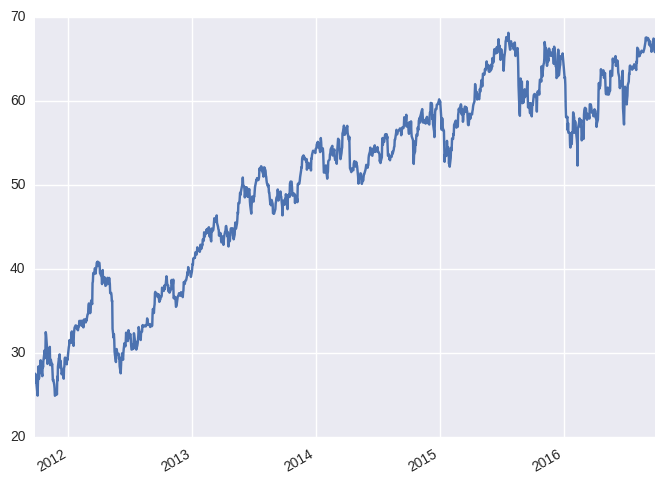

In [145]:
plt.figure(figsize=(8,6))
test_phase_data['Trade Price'].plot()

In [146]:
start_time = time.time()
result_list = chimp_simulate(data_full=data_full, target_data=test_phase_data, num_iter=5000, train_size=21*35, batch_size=7, random_state=0)
print("\nSimulation for Test set took {} seconds.".format(time.time() - start_time))

DatetimeIndex(['2011-09-26', '2011-09-27', '2011-09-28', '2011-09-29',
               '2011-09-30', '2011-10-03', '2011-10-04', '2011-10-05',
               '2011-10-06', '2011-10-07',
               ...
               '2016-09-14', '2016-09-15', '2016-09-16', '2016-09-19',
               '2016-09-20', '2016-09-21', '2016-09-22', '2016-09-23',
               '2016-09-26', '2016-09-27'],
              dtype='datetime64[ns]', length=1260, freq=None)
Batch 1
Running the first time...no prevs exist.
No reward yet...0 assigned.
Updating Q model...
First time running...
No cheatsheet to pass over yet...no worries!
Running the first time...no prevs exist.
No reward yet...0 assigned.
Batch 2
Running the first time...no prevs exist.
No reward yet...0 assigned.
Updating Q model...
Batch 3
Running the first time...no prevs exist.
No reward yet...0 assigned.
Updating Q model...
[1000.0, 997.49836000000005, 963.10100799999987, 963.10100799999987, 963.10100799999987, 963.10100799999987, 963.10100799

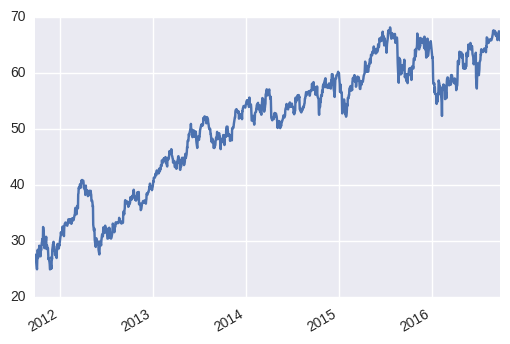

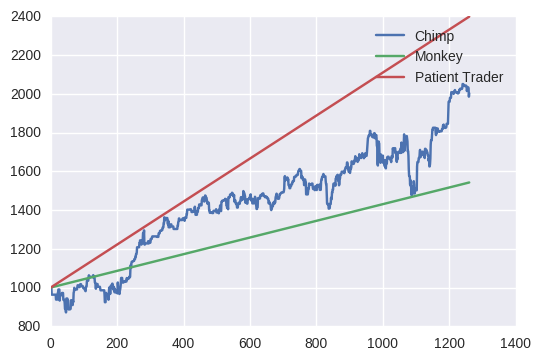

In [154]:
pv_history_list = result_list[0]
temp_pv_list = [1000]
temp_pv_list.extend(pv_history_list)
pv_history_list = temp_pv_list

plt.figure(figsize=(6,4))
test_phase_data['Trade Price'].plot()

plt.figure(figsize=(6,4))
plt.plot(pv_history_list, label='Chimp')

monkey_x = np.arange(len(pv_history_list))
monkey_y = ((1542.635 - 1000)/ len(pv_history_list)) * monkey_x + 1000
plt.plot(monkey_x, monkey_y, label='Monkey')

pt_x = np.arange(len(pv_history_list))
pt_y = ((2399.255 - 1000)/ len(pv_history_list)) * monkey_x + 1000
plt.plot(pt_x, pt_y, label='Patient Trader')

plt.legend()

In [1058]:
def inverse_percentile(arr, num):
    arr = sorted(arr)
    i_arr = [i for i, x in enumerate(arr) if x > num]
   
    return i_arr[0] / len(arr) if len(i_arr) > 0 else 1 

print(inverse_percentile(monkey_test.pv_history_list, 2002.4698289999994))

0.81995


The result turns out to be above the median by quite a lot (above 82% of the Monkeys). 

And when we look at the equivalent annual ROI:

$$
ROI = (1 + r)^{1260/252} = 2.0025
$$

$$
\Longrightarrow r = 0.1489854 \approx 14.90\%
$$

It is certainly not as impressive as what she did on the cross-validation dataset which means we have probably overfitted the cv dataset with the grid search. Although it is above about 82% of the Monkeys (with median equal to 9.06%), it can still be pure chance and plus, with all the effort, it still can't beat the PT (19.13%). Let's try to refine it a bit.

### Refinement
Surely we wouldn't expect the Chimp to give us a 33% of ROI on the test dataset when there is 2008 financial crisis, which though not impossible, is quite unlikely. However there surely is room for improvement. One way to refine it is to do it on the reinforcement learning part. It could be that the God Chimp is doing her job way too well. We can think of the God Chimp as someone who can see the future. And if you think about it: 1. we have someone who can see the future, 2. there's no trading cost. This means this "someone" will make use of every possible ups and downs to make all the money he or she wishes to. And this is bad, because he or she can make money out of the noise too, and we can't model the noise. If most of the time our model is trying to fit the noise, then it's not very good.

So to fix this, we can introduce trading cost on the training stage so if it were just small ups and downs, the Chimp would refrain herself from being too greedy or she would be penalized by the trading cost.

In [157]:
class MonkeyBot(object):
    def __init__(self, dfEnv, cash=1000, share=0, pv=0, random_state=0):
        random.seed(random_state)
        np.random.seed(random_state)
        
        self.cash = cash
        self.share = share
        self.pv = pv
        self.asset_history_list = []
        self.action_list = []
        
        self.env = deepcopy(dfEnv)

    def buy(self, stock_price, cost, fold=1):
        if self.cash < stock_price:
            self.hold(stock_price)
            
        else:
            num_affordable = int(self.cash // stock_price)
            buy_amount = int(num_affordable // fold)
            self.cash = self.cash - stock_price * buy_amount
            self.share = self.share + buy_amount
            self.pv = stock_price * self.share

             # Adding transaction cost
            self.trading_cost(buy_amount, cost)
            
        # Append action to action list
        self.action_list.append('Buy')

    def sell(self, stock_price, cost, fold=1):
        if self.share == 0:
            self.hold(stock_price)
            
        else:
            sell_amount = int(self.share // fold)
            self.cash = self.cash + stock_price * sell_amount
            self.pv = 0
            self.share = 0

            # Adding transaction cost
            self.trading_cost(sell_amount, cost)
            
        self.action_list.append('Sell')

    def hold(self, stock_price):
        self.pv = stock_price * self.share

    def trading_cost(self, trading_amount, cost):
            if cost is None:
                pass                
            elif cost == 'low':
                if trading_amount * 0.01 < 1.99:
                    self.cash = self.cash - 1.99
                else:
                    self.cash = self.cash - trading_amount * 0.01
            elif cost == 'medium':
                if trading_amount * 0.01 < 5:
                    self.cash = self.cash - 5
                else:
                    self.cash = self.cash - trading_amount * 0.01
            elif cost == 'high':
                if trading_amount * 0.01 < 7:
                    self.cash = self.cash - 7
                else:
                    self.cash = self.cash - trading_amount * 0.01
            else:
                raise ValueError("Invalid cost parameter!")
        
    def reset(self):
        self.cash = 1000
        self.share = 0
        self.pv = 0

    def make_decision(self, x, cost):
        random_choice = random.choice([1, 2])

        if random_choice == 0:
            self.hold(x)
        elif random_choice == 1:
            self.buy(x, cost)
        elif random_choice == 2:
            self.sell(x, cost)
        else:
            raise ValueError("Invalid choice!")

        return self.pv # for frame-wise operation

    def simulate(self, iters, cost=None):
        start_time = time.time()
        for i in range(iters):
            for index, row in self.env.iterrows():
                self.make_decision(row['Trade Price'], cost)
            self.asset_history_list.append(self.pv + self.cash)
            self.reset()
        print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))
        
        return self.asset_history_list, self.action_list

In [173]:
import sys

class ChimpBot(MonkeyBot):
    """An agent that learns to drive in the smartcab world."""
    
    def __init__(self, dfEnv, iter_random_rounds, gamma, random_state=0, test_mode=False, cash=1000, share=0, pv=0):
        super(ChimpBot, self).__init__(dfEnv, iter_random_rounds, cash, share, pv)
        # From MonkeyBot:
        # sets self.cash = 1000
        # sets self.share = 0
        # sets self.pv = 0
        # sets self.pv_history_list = []
        # sets self.env = dfEnv
        # implements buy(self, stock_price)
        # implements sell(self, stock_price)
        # implements hold(self)

        # Set random state
        self.random_state = random_state
        random.seed(self.random_state)
        np.random.seed(self.random_state)
        
        # Chimp parameters
        self.valid_actions = ['Buy', 'Sell']
        self.gamma = gamma # Discount factor
        self.epsilon = 1 # Exploration-exploitation
        self.test_mode = test_mode
        self.random_rounds = iter_random_rounds # Number of rounds where the bot chooses to go monkey
        self.num_features = len(dfEnv.columns) # Use every columns from the input data
        
        # Turn input data into index, row
        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = self.iter_env.next()

        # Numpy alternative
#         self.env_arr = self.env.values
#         self.now_row = 0

        # May need to put back later
#         self.prev_cash = self.cash
#         self.prev_share = self.share
#         self.prev_pv = self.pv

        # Q-table and q_df
        self.q_df_columns = list(self.env.columns)
        self.q_df_columns.extend(['Action', 'Q Value'])
        self.q_df = pd.DataFrame(columns=self.q_df_columns)
        
        self.q_dict = defaultdict(lambda: (0, 0)) # element of q_dict is (state, act): (q_value, t)
        self.q_dict_analysis = defaultdict(lambda: (0, 0))

        # Misc
        self.reset_counter = 0

    def make_q_df(self):
        """Make a q_df out of the q_dict."""
#         print("Making q_df...")
        result_dict = defaultdict(list)
        for index, row in self.q_dict.iteritems():
            for i in range(len(self.q_dict.keys()[0])):
                column_name = 'col' + str(i + 1)
                result_dict[column_name].append(index[i])
            result_dict['Q'].append(self.q_dict[index][0])

        self.q_df = pd.DataFrame(result_dict)
        q_df_column_list = ['col' + str(x) for x in range(1, self.num_features - 1 + 1 + 1)] # features + action
        q_df_column_list.append('Q')
        self.q_df = self.q_df[q_df_column_list]

        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Wrong action!")

        def str_float_int(x):
            return int(float(x))

        arr_int = np.vectorize(str_float_int)

#         print(self.q_df.head())
        self.q_df.ix[:, -2] = self.q_df.ix[:, -2].apply(transfer_action)
        self.q_df.ix[:, :-1] = self.q_df.ix[:, :-1].apply(arr_int) # Maybe useless

    def split_q_df(self):
        """Splitting q_df into features and labels."""
        
        self.q_df_X = self.q_df.ix[:, :-1]
        self.q_df_y = self.q_df.ix[:, -1]

    def train_on_q_df(self):
        """Model the q_df."""
#         print("Training on q_df...")
        self.q_reg = RandomForestRegressor(n_estimators=2000, max_features='sqrt', n_jobs=-1, random_state=self.random_state)
        self.q_reg = self.q_reg.fit(self.q_df_X, self.q_df_y)

    def update_q_model(self):
        """1. Make q_df
           2. Split q_df
           3. Train on q_df
        """
#         print("Updating Q model...")
#         start_time = time.time()
        self.make_q_df()
        self.split_q_df()
        self.train_on_q_df()
#         print("Update took {} seconds".format(time.time() - start_time))

    def from_state_action_predict_q(self, state_action):
        """Make prediction using self.reg"""
        state_action = [state_action]
        pred_q = self.q_reg.predict(state_action)

        return pred_q

    def max_q(self):
#         print("Calculating Max Q")
        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Invalid action!")

#         def str_float_int(x):
#             return int(float(x))

        max_q = None
        q_compare_dict = {}

        if len(self.now_states) != self.num_features - 1:
            raise ValueError("Got ya bastard! @ MaxQ")

        # Populate the q_dict
        for act in set(self.valid_actions):
            # added 1 more additional features to the feature set
            self.now_states.append(act)
            now_row_key = tuple(self.now_states)

            _ = self.q_dict[now_row_key]

            try:
                self.q_reg
            except AttributeError:
                pass
                # print('No q_reg yet...going with default.')
            else:
                if _[1] == 0:
                    # print("Dreaming mode...")                    
                    single_X = np.array(now_row_key)
                    # print(single_X)
#                     arr_int = np.vectorize(str_float_int)
                    single_X[-1] = transfer_action(single_X[-1])
#                     single_X = arr_int(single_X)
                    single_X = single_X.reshape(1, -1)
                    pred_q = self.q_reg.predict(single_X)
                    dreamed_q = (1 - (1 / (self.q_dict[now_row_key][1] + 1))) * self.q_dict[now_row_key][0] + (1 / (self.q_dict[now_row_key][1] + 1)) * pred_q[0]
                    self.q_dict[now_row_key] = (dreamed_q, self.q_dict[now_row_key][1] + 1)

            q_compare_dict[now_row_key] = self.q_dict[now_row_key]
            self.now_states.pop()

        try:
            key, qAndT = max(q_compare_dict.iteritems(), key=lambda x:x[1])
        except ValueError:
            print("Wrong Q Value in Q Compare Dict!")
            sys.exit(1)
        else:
            return key[-1], qAndT[0], qAndT[1]

    def q_update(self):
#         print("Updating Q table...")
        # prev_states.append(self.prev_yes_share)
        self.prev_states.append(self.prev_action)
        prev_states_key = tuple(self.prev_states)

        if len(prev_states_key) != self.num_features - 1 + 1:
            raise ValueError("Got ya bastard! @ Q_Update")

        q_temp = self.q_dict[prev_states_key]
        q_temp0 = (1 - (1 / (q_temp[1] + 1))) * q_temp[0] + (1 / (q_temp[1] + 1)) * (self.reward + self.gamma * self.max_q()[1])

        self.q_dict[prev_states_key] = (q_temp0, q_temp[1] + 1)
        # For analysis purpose
        self.q_dict_analysis[prev_states_key] = (q_temp0, self.prev_env_index)

    def reset(self):
#         print("Resetting...")
        # Portfolio change over iterations
        self.asset_history_list.append(self.pv + self.cash)

        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = self.iter_env.next()
#         self.now_row = 0 # Numpy option

        self.cash = 1000
        self.share = 0
        self.pv = 0

        # Delete all prevs
        del self.prev_states
        del self.prev_env_index        
        del self.prev_cash
        del self.prev_share
        del self.prev_pv
        del self.prev_action

        if self.test_mode is True:
            self.epsilon = 0
        
        else:
            if self.epsilon - 1/self.random_rounds > 0.00001: # Epislon threshold: 0.01
                self.epsilon = self.epsilon - 1/self.random_rounds
            else:
                self.epsilon = 0.00001 # Epislon threshold: 0.1
                
        self.reset_counter += 1

        if self.reset_counter % self.random_rounds == 0:
            self.update_q_model()

        if np.abs(self.epsilon - 0.00001) > 0.000001:
            self.action_list = []

    def make_decision(self):
        return self.max_q()[0]

    def update(self, cost):
        # Update state
        self.now_states = list(self.now_row)
        self.now_states.pop() # Remove Trade Price

### Numpy option
#         try:
#             self.now_states = list(self.env_arr[self.now_row])
#         except IndexError:
#             print("End of data.")
#             sys.exit(1)
#         self.now_states.pop() # Remove Trade Price

        if len(self.now_states) != self.num_features - 1:
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the self.now_row!!!")

        # Update Q-table using prevs
        try:
            self.prev_states
        except AttributeError:
            pass
#             print("Running the first time...no prevs exist.")
        else:
            self.hold(self.now_row[-1])
            self.reward = ((self.cash - self.prev_cash) + (self.pv - self.prev_pv)) / (self.prev_cash + self.prev_pv)
            self.q_update()

        # All the prev stuff!
        self.prev_states = copy(self.now_states)
        self.prev_env_index = deepcopy(self.now_env_index)
#         self.prev_env_index = self.env.index[self.now_row] # Numpy option
        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv
        
        # Exploitation-exploration decisioning
        self.decision = np.random.choice(2, p = [self.epsilon, 1 - self.epsilon]) # decide to go random or with the policy
        # self.decision = 0 # Force random mode

        # print("Random decision: {0}, Epislon: {1}".format(self.decision, self.epsilon))
        if self.decision == 0: # if zero, go random
            action = random.choice(self.valid_actions)
        else: # else go with the policy
            action = self.make_decision()

        # Execute action and get reward
        if action == 'Buy':
            # print(self.now_row)
            self.buy(self.now_row[-1], cost)
#             self.buy(self.env_arr[self.now_row][-1], cost) # Numpy option
        elif action == 'Sell':
            # print(self.now_row)
            self.sell(self.now_row[-1], cost)
#             self.sell(self.env_arr[self.now_row][-1], cost) # Numpy option
        elif action == 'Hold':
            # print(self.now_row)
            self.hold(self.now_row[-1])
#             self.hold(self.env_arr[self.now_row][-1]) # Numpy option
        else:
            raise ValueError("Invalid action man!")
        
        self.prev_action = action
        
#         self.now_row += 1 # Numpy option

        try:
            self.now_env_index, self.now_row = self.iter_env.next()
        except StopIteration:
            pass

    def simulate(self, cost=None):
        start_time = time.time()

        for i in range(self.random_rounds):
            for l in range(len(self.env)):
#             for l in range(len(self.env_arr)): # Numpy option
                self.update(cost)
            self.reset()
            if (i + 1) % 500 == 0:
                print(self.asset_history_list[-1])
                print("Round {} finished".format(i + 1))
#             print(self.asset_history_list[-1])
#             print("Round {} finished".format(i + 1))
        print("{0} rounds of simulation with cost = {1}, took {2} seconds".format(self.random_rounds, cost, time.time() - start_time))
        return self.asset_history_list, self.action_list

In [174]:
def chimp_simulate(data_full, target_data, num_iter, gamma, train_size, batch_size, random_state=0):
    pv_history_list = []
    action_lists = []
    # Initiating data and the chimp
    start_date = target_data.index[0]
    end_date = target_data.index[-1]
    
    dfFull = data_full
    date_range = target_data.index[:] # Using 7 months of data to predict one month
    print(date_range)
    
    batch_count = 0
        
    cash = 1000
    share = 0
    pv = 0
    now_yes_share = 0

    for batch in range(len(target_data) // batch_size + 1):
        
#     for date in date_range:
        batch_count += 1
        print("Batch {}".format(batch_count))

        try:
            dfTest = dfFull.ix[target_data.index[batch * batch_size]:target_data.index[batch * batch_size + batch_size - 1]]
        except IndexError:
            print("Last batch size unmatched...but may be fine!")
            try: 
                dfTest = dfFull.ix[target_data.index[batch * batch_size]:target_data.index[-1]]
            except IndexError:
                print("End of data")
                return (pv_history_list, action_lists)
        
        (u,) = dfFull.index.get_indexer_for([target_data.index[batch * batch_size]])

        dfTrain = dfFull.iloc[u - (train_size):u]

        chimp_train = ChimpBot(dfTrain, iter_random_rounds=num_iter, gamma=gamma, random_state=0)

        for i in range(num_iter):
            for l in range(len(chimp_train.env)):
                # print("Train Round {0}-{1}".format(i + 1, l + 1))
                chimp_train.update('high')
            chimp_train.reset()

        # Test the Chimp!
#         q_df = deepcopy(chimp_train.q_df)
#         q_dict = deepcopy(chimp_train.q_dict)
#         q_reg = deepcopy(chimp_train.q_reg)

        try:
            _ = chimp_test
        except NameError:
            print("First time running...")
                    
#             now_yes_share = chimp_test.now_yes_share

        chimp_test = ChimpBot(dfTest, iter_random_rounds=num_iter, gamma=gamma, random_state=0)
        
        chimp_test.q_df = deepcopy(chimp_train.q_df)
        chimp_test.q_dict = deepcopy(chimp_train.q_dict)
        chimp_test.q_reg = deepcopy(chimp_train.q_reg)
        chimp_test.epsilon = 0

        # Pass the cheatsheet to the next chimp
        try:
            chimp_test.cash = cash
            chimp_test.share = share
            chimp_test.pv = pv
            
            chimp_test.prev_states = prev_states
#             chimp_test.now_action = now_action
            chimp_test.prev_action = prev_action
#             chimp_test.prev_yes_share = prev_yes_share
            chimp_test.reward = reward
            chimp_test.prev_cash = prev_cash
            chimp_test.prev_share = prev_share
            chimp_test.prev_pv = prev_pv
            chimp_test.prev_env_index = prev_env_index

        except UnboundLocalError:
            print("No cheatsheet to pass over yet...no worries!")

        for l in range(len(chimp_test.env)):
            # print("Train Round {0}-{1}".format(i + 1, l + 1))
            chimp_test.update(None)
            action_lists.append(chimp_test.action_list)
            pv_history_list.append(chimp_test.cash + chimp_test.pv)

                
        # Create cheatsheet for the next chimp
        cash = chimp_test.cash
        share = chimp_test.share
        pv = chimp_test.pv
            
        prev_states = chimp_test.prev_states
#         now_action = chimp_test.now_action
        prev_action = chimp_test.prev_action
#         prev_yes_share = chimp_test.prev_yes_share
        prev_env_index = chimp_test.prev_env_index
        reward = chimp_test.reward
        prev_cash = chimp_test.prev_cash
        prev_share = chimp_test.prev_share
        prev_pv = chimp_test.prev_pv
        
        if (batch + 1) % 3 == 0:
            print(pv_history_list)
        
    print(pv_history_list)
    
#     return (pv_history_list, action_lists)
    return pv_history_list

In [176]:
# start_time = time.time()
result_list = chimp_simulate(data_full=data_full, target_data=test_phase_data, num_iter=5000, gamma=0.75, train_size=21*35, batch_size=7, random_state=0)
print("\nSimulation for Test set took {} seconds.".format(time.time() - start_time))

DatetimeIndex(['2011-09-26', '2011-09-27', '2011-09-28', '2011-09-29',
               '2011-09-30', '2011-10-03', '2011-10-04', '2011-10-05',
               '2011-10-06', '2011-10-07',
               ...
               '2016-09-14', '2016-09-15', '2016-09-16', '2016-09-19',
               '2016-09-20', '2016-09-21', '2016-09-22', '2016-09-23',
               '2016-09-26', '2016-09-27'],
              dtype='datetime64[ns]', length=1260, freq=None)
Batch 1
First time running...
No cheatsheet to pass over yet...no worries!
Batch 2
Batch 3
[1000.0, 997.49836000000005, 963.10100799999987, 963.10100799999987, 963.10100799999987, 963.10100799999987, 1025.0354599999998, 1044.348352, 1095.6274519999997, 1095.6274519999997, 1095.6274519999997, 1095.6274519999997, 1095.6274519999997, 1095.6274519999997, 1095.6274519999997, 1066.5792769999998, 1066.5792769999998, 1066.5792769999998, 1095.1105319999999, 1104.5127500000001, 1104.5127500000001]
Batch 4
Batch 5
Batch 6
[1000.0, 997.49836000000005, 96

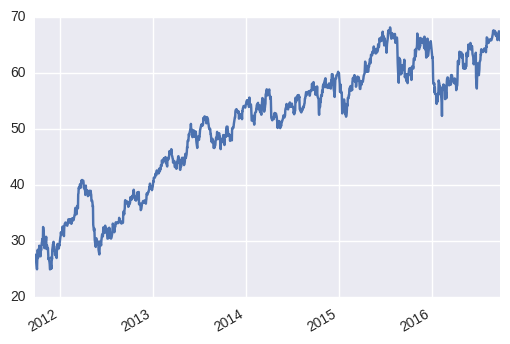

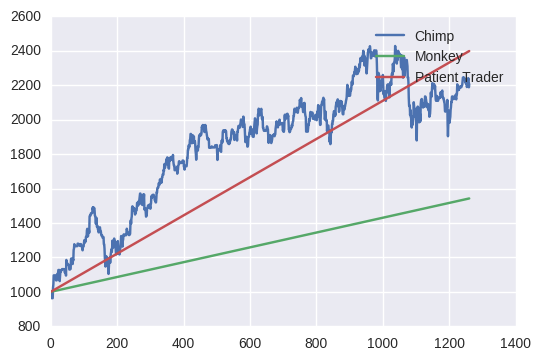

In [177]:
pv_history_list = result_list[0]
temp_pv_list = [1000]
temp_pv_list.extend(pv_history_list)
pv_history_list = temp_pv_list

plt.figure(figsize=(6,4))
test_phase_data['Trade Price'].plot()

plt.figure(figsize=(6,4))
plt.plot(pv_history_list, label='Chimp')

monkey_x = np.arange(len(pv_history_list))
monkey_y = ((1542.635 - 1000)/ len(pv_history_list)) * monkey_x + 1000
plt.plot(monkey_x, monkey_y, label='Monkey')

pt_x = np.arange(len(pv_history_list))
pt_y = ((2399.255 - 1000)/ len(pv_history_list)) * monkey_x + 1000
plt.plot(pt_x, pt_y, label='Patient Trader')

plt.legend()

In [187]:
print(inverse_percentile(monkey_test.pv_history_list, 2206.8424410000021))

0.89706


Seems like our refinement has beaten 89.7 percent of the Monkeys.

Let's look at the equivalent annual ROI:

$$
ROI = (1 + r)^{1260/252} = 2.2068
$$

$$
\Longrightarrow r = 0.1715278 \approx 17.15\%
$$

## Results
### Model Evaluation and Validation
The number of iterations required for the Q-table to converge is tightly related to the number of valid actions and the discount factor. We set our discount factor $\gamma = 0.75$, and with two possible valid actions, any rewards that happen 10 days from the day of interest will be discounted to less than 5%. This means exploring all the possible actions would require roughly $2^{10}$ of iterations (given that we have only two valid actions). Therefore, 5000 iterations as what we have done earlier should guarantee a good convergence.

### Justification
The result shows that our Chimp performs better than 89.7% of the Monkeys, which has not yet achieved statistical significance but seems to be a good start. For our trading bot to be useful, we need to test it against more stocks and make it outperform the PT in general. Due to that lack of resources, we won't cover that is this report.

## Conclusion
### Reflection
This is a really interesting and challenging project for me for a few reasons. First is that I wasn't really familiar with time series data, and second is that I've never bought any stocks and had zero knowledge of the stock market whatsoever.

I started out using only supervised learning, and my first submit (which was like three months ago) wasn't very successful. I was then advised by my reviewer to try out some time series specific techiques such as ARIMA, which I did and failed, and reinforcement learning, which is what I'm using now. And though it hasn't achieved the level for practical use, I feel that this is the right way to go. About one month I after I started going with this approach, I was actually contacted on LinkedIn by the CEO of a Fintech sponsored hedge fund. And I realized they were actually doing something really similar, only that they were doing it with deep learning. This makes me feel more confident about this approach. I really want to thank my first reviewer for leading me to this path!

Following are some of the words of my reflection on my first submit:

*There were quite a few places that I found puzzled and difficult.*

*First is the benchmark. I had no idea what a reasonable benchmark should be. How precise the prediction need to be? How far into the future do I want to predict? And can I predict that with the data?*

*The second is working with time series data. It's my first time working with time series data. The "physics" behind the scene is dynamic and time-dependent. How do I convert this data into something I can work with traditional machine learning methods, without losing information and constrains?*

*Third comes to model building. Should we build one model to predict for all the stocks? Or should we build one for each? If I build each of them independently, how do I incorporate sector information?*

*There are a lot more than what I've listed here, but these are the ones that came to mind first and were definitely among the hardest. However, though the word difficulty is used here, never for a second did I think any of them was difficult. Now that I think back, I think it's because I didn't know what would a reasonable goal be so there was not much pressure. The only thing that kept driving me forward was how to improve it, how to make it better. All of these questions are not so easy to answer, but my ignorance definitely lent me a hand this time.*

It's intersting to look back on what I felt three months ago. A lot of things was really fresh an new to me back then but now it all feels quite natural to me. I really like this project. It got me into trading, and has made me more interested in reinforcement learning.


### Improvement
1. **Try out a different feature set—**we basically hand-picked our features in the hope that they could capture the patterns of the stock market. Our selection was based on volume price analysis but it may very well not be a good representation of what good VPA pracitioners are really doing. So one way to do this is to include more raw features (say we use tick data to the minute, and trace back more days) and then use PCA or an autoencoder to compress all that information. We can then use RFE or other feature selection methods to pick the better ones.

2. **Feature discretization my not ideal—**since the feature space is vast, one way or the other we are only going to cover a fraction of the space. As such, discretizing it really won't give us any benefits. In doing so we're actually losing a lot of information.

3. **Use other data—**we may also include economic data and social data so the trading bot can capture more than just what VPA method can capture.

4. **Try out different parameters on reinforcement learning—**the best trading stratege is that we make every order placement counts. To achieve this we can increase the discount factor and the trading cost.

5. **Try out different algorithms on supervised learning—**yes, I'm talking about deep learning!